In [69]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import missingno

from scipy.stats import chi2_contingency, ks_2samp, pointbiserialr, spearmanr
from imblearn.over_sampling import SMOTENC
from optbinning import BinningProcess

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import matthews_corrcoef, roc_auc_score, confusion_matrix, recall_score, precision_score, accuracy_score, roc_curve, f1_score, brier_score_loss
 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

Parameters' initialization
- seed: in order to preserve the reproducibility of this Python notebook
- test_size, validation_size: percentage splits

In [70]:
seed = 3490857
test_size = 0.15
validation_size = test_size/(1 - test_size)

In [71]:
data = pd.read_csv('./data/raw_data.csv')

In [72]:
data

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [75]:
def categorical_continuous_vars(df: pd.DataFrame, target:str = 'BAD') -> tuple[list, list]:
    cat_vars = [col for col in df.columns if df[col].dtypes == 'O' and col != target]
    cont_vars = [col for col in df.columns if col not in cat_vars + [target]]

    return (cat_vars, cont_vars)

In [76]:
cat_vars, cont_vars = categorical_continuous_vars(data)

In [246]:
print(f'Categorical features: {", ".join(cat_vars)}')
print(f'Categorical features: {", ".join(cont_vars)}')

Categorical features: REASON, JOB
Categorical features: LOAN, MORTDUE, VALUE, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC


In [79]:
def na_dendogram(df:pd.DataFrame, export:bool = False):

    #True/False values indicating whether a column has some NA's.
    na_columns_indicators = df.describe(include = 'all').T['count'] < df.shape[0]
    #Filtering the column names having NA's.
    na_columns = df.columns[na_columns_indicators]
    #Subsetting the data based on the NA's columns.
    final_df_dendogram = df[na_columns]

    #Plotting the dendogram
    missingno.dendrogram(final_df_dendogram, orientation = 'top')
    plt.title("Dendogram of variables having NA's")

    plt.tight_layout()

    #Exporting the plot
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/NA_Dendogram.jpg', dpi = 1200)
    
    plt.show()

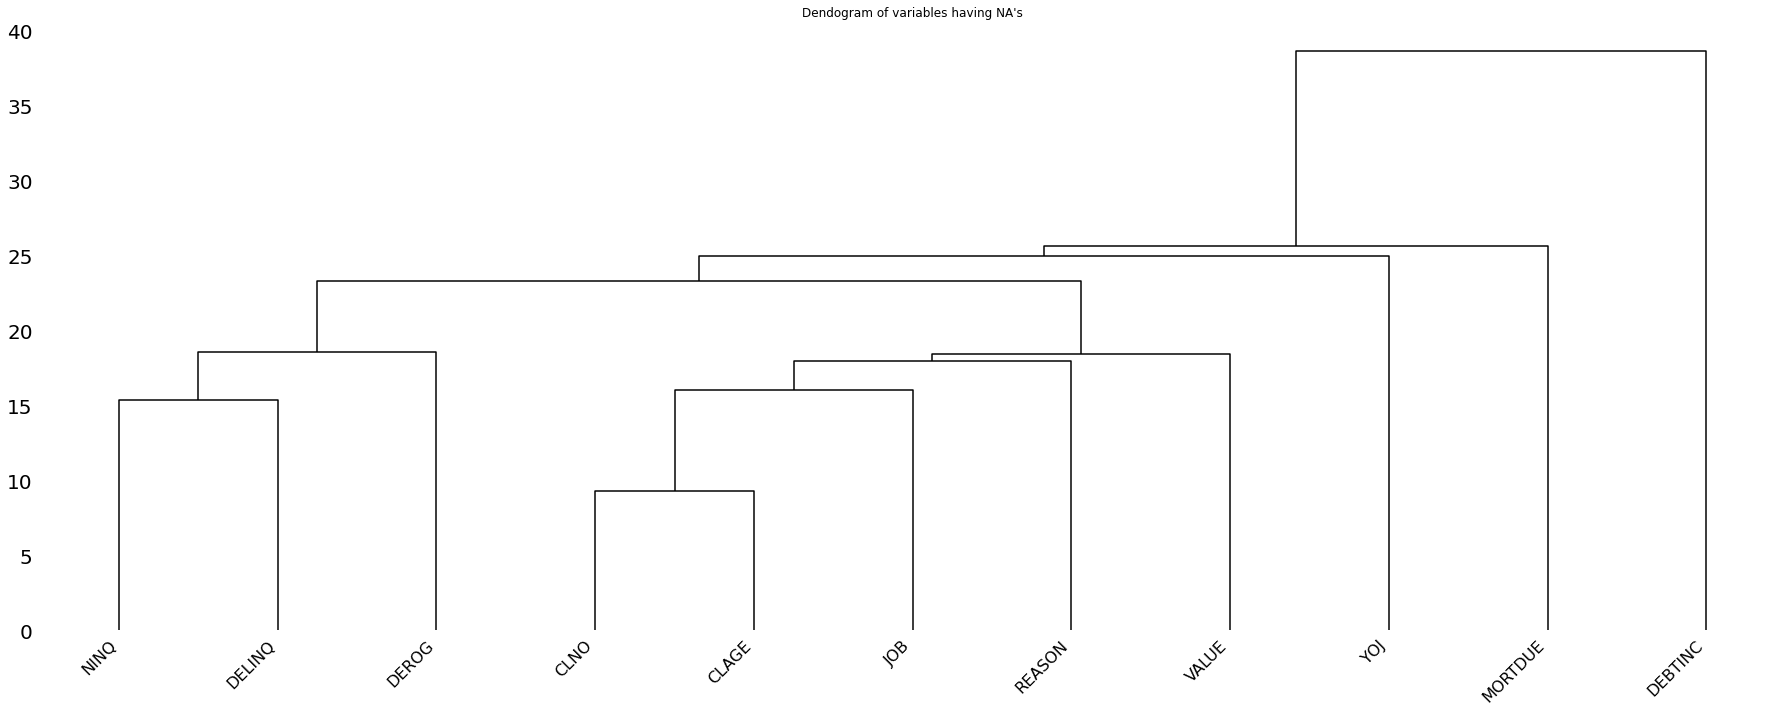

In [80]:
na_dendogram(data, export = True)

In [81]:
def default_distribution_plot(df:pd.DataFrame, target:str = 'BAD', export:bool = False):  
    
    #Replacing the Booleans with non-default/default strings for visualization
    df_plot = df[target].copy().replace({0: 'Non-default', 1:'Default'})

    #Figure's initialization
    plt.figure(figsize = (8, 6))
    
    #Default distribution
    sns.countplot(df_plot, order = reversed(df_plot.unique()), palette = 'BuPu')
    
    plt.title('Default Distribution', fontsize = 13)
    plt.xticks(fontsize = 11)
    plt.xlabel(None)

    #Removing upper and right axes spines
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    
    #Exporting plot
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Default_Distribution.jpg', dpi = 1200)

    plt.show()

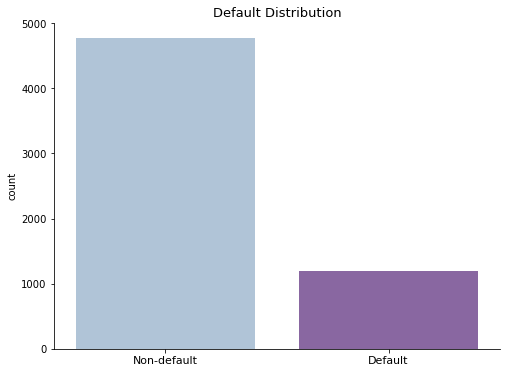

In [82]:
default_distribution_plot(data, export = True)

In [83]:
def continuous_distribution_plot(df: pd.DataFrame, cont_vars: list,
                                 plot_type: str, target: str = 'BAD', 
                                 export: bool = False):

    #Possible plot types
    plot_types = {'boxplot': sns.boxplot,
                  'violinplot': sns.violinplot,
                  'histogram': sns.histplot}

    #Plot type parameter check
    if plot_type not in plot_types.keys():
        raise ValueError(f'Invalid plot type. Please, select one of these available plot types: {", ".join([key for key in plot_types.keys()])}')

    #Plot either boxplots or violinplots
    if plot_type in ['boxplot', 'violinplot']:
        
        #replace 0/1's with (Non)-default texts for visualization's sake.
        df_plot = df.copy()
        df_plot[target] = df_plot[target].replace({0: 'Non-default', 1: 'Default'})

        #Figure's and axes' initialization
        fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (11, 25))

        for ax, var in zip(axs.ravel(), cont_vars):
            
            #Boxplot/violinplot
            plot_types[plot_type](data = df_plot, x = target, y = var, ax = ax,
                                  palette = 'BuPu', order = ['Non-default', 'Default'])

            ax.set_title(f'Distribution of {var}', size = 13)
            ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
            ax.set(xlabel = None)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        plt.tight_layout()
        fig.suptitle("Distribution of Continuous Features", fontsize = 16)
        fig.subplots_adjust(top=0.95)
        #Exporting the plots
        if export:
            os.makedirs('./plots/', exist_ok = True)
            plt.savefig(f'./plots/Continuous_Features_Distribution_{plot_type.capitalize()}s.jpg', dpi = 1200)
        plt.show()


    #Plot histograms
    elif plot_type == 'histogram':

        #Figure's and axes' initialization
        fig, axs = plt.subplots(nrows = len(cont_vars), ncols = 2, figsize = (11, 35))

        #Column index
        col_ind = 0
        #Axis index (if the value is even, the plot will be located on the left side, otherwise on the right side)
        axis_count = 0

        for ax in axs.ravel():

            #Accessing the feature name.
            var = cont_vars[col_ind]
            #Subsetting the data based on the feature.
            var_series = df[var]

            #Calculating the bin size for given feature ensuring that both conditional plots (left and right) will have the same number of bins.
                #Using rule of thumb (Scott, 1979) - https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
       
            R = var_series.max() - var_series.min() #Range of the feature's values
            n = len(var_series) #Number of feature's values
            sigma = var_series.std() #Standard deviation of the feature's values
        
            #Number of bins
            no_bins = int(R*(n**(1/3))/(3.49*sigma))

            #The left side (even axis_count) depicts the features' distribution conditional on the non-default cases.
            if axis_count % 2 == 0:
                #Subsetting the data for non-default cases only.
                df_subset= df.query(f'{target} == 0')
                #Number of missing values within given feature
                no_missings = df_subset[var].isna().sum()
                #Percentage of missing values within subset of given feature (i.e., percentage of missing values of given feature within the non-default cases)
                pct_missings = no_missings/df_subset.shape[0] * 100

                #Histogram with kernel density function
                plot_types[plot_type](data = df_subset, x = var, ax = ax, bins = no_bins,
                                binrange = ((var_series.min(), var_series.max())), #binrange to ensure that both left and right plot will have the same data range.
                                kde = True, color = 'lightblue')
 
                ax.set_title(f'Distribution of {var} (Non-default cases)', size = 13)
                ax.tick_params(axis = 'both', which = 'major', labelsize = 11, rotation = 30)
                ax.set(xlabel = None)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                #Inserting a text box with an information about the missing values.
                ax.text(0.7, 0.9, f"Number of NA's: {no_missings} ({pct_missings:.1f}%)",
                       horizontalalignment = 'center', verticalalignment = 'center',
                       transform = ax.transAxes, bbox = dict(facecolor = 'pink', alpha = 0.3))

            #The right side (odd axis_count) depicts the features' distribution conditional on the default cases.
            else:
                #Subsetting the data for default cases only.
                df_subset = df.query(f'{target} == 1')
                #Number of missing values within given feature
                no_missings = df_subset[var].isna().sum()
                #Percentage of missing values within subset of given feature (i.e., percentage of missing values of given feature within the default cases)
                pct_missings = no_missings/df_subset.shape[0] * 100

                #Histogram with kernel density function
                sns.histplot(data = df_subset, x = var, ax = ax, bins = no_bins,
                                binrange = ((var_series.min(), var_series.max())), #binrange to ensure that both left and right plot will have the same data range.
                                kde = True, color = 'mediumpurple')
                
                ax.set_title(f'Distribution of {var} (Default cases)', size = 13)
                ax.tick_params(axis = 'both', which = 'major', labelsize = 11, rotation = 30)
                ax.set(xlabel = None)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                #Inserting a text box with an information about the missing values.
                ax.text(0.7, 0.9, f"Number of NA's: {no_missings} ({pct_missings:.1f}%)",
                        horizontalalignment = 'center', verticalalignment = 'center',
                        transform = ax.transAxes, bbox = dict(facecolor = 'pink', alpha = 0.3))
                
                #Proceeding with the next feature
                col_ind += 1

            #Switching to the left/right side of the figure
            axis_count +=1
        
        plt.tight_layout()
        fig.suptitle("Distribution of Continuous Features", fontsize = 16)
        fig.subplots_adjust(top=0.95)
        #Exporting the plots
        if export:
            os.makedirs('./plots/', exist_ok = True)
            plt.savefig(f'./plots/Continuous_Features_Distribution_{plot_type.capitalize()}s.jpg', dpi = 1200)
    
        plt.show()

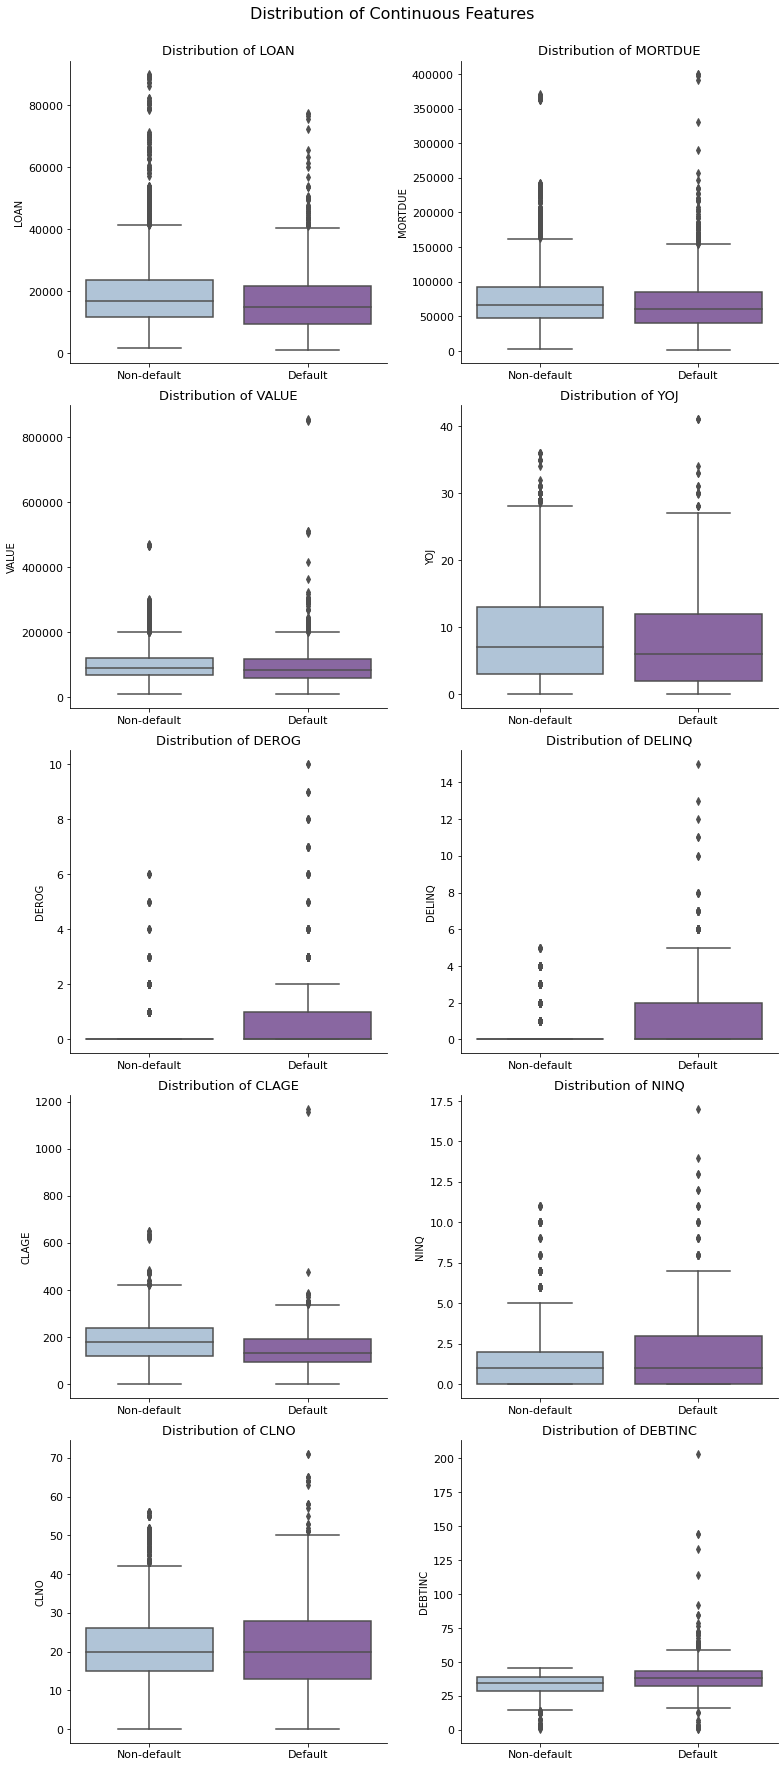

In [84]:
continuous_distribution_plot(data, cont_vars, plot_type = 'boxplot',
                             export = True)

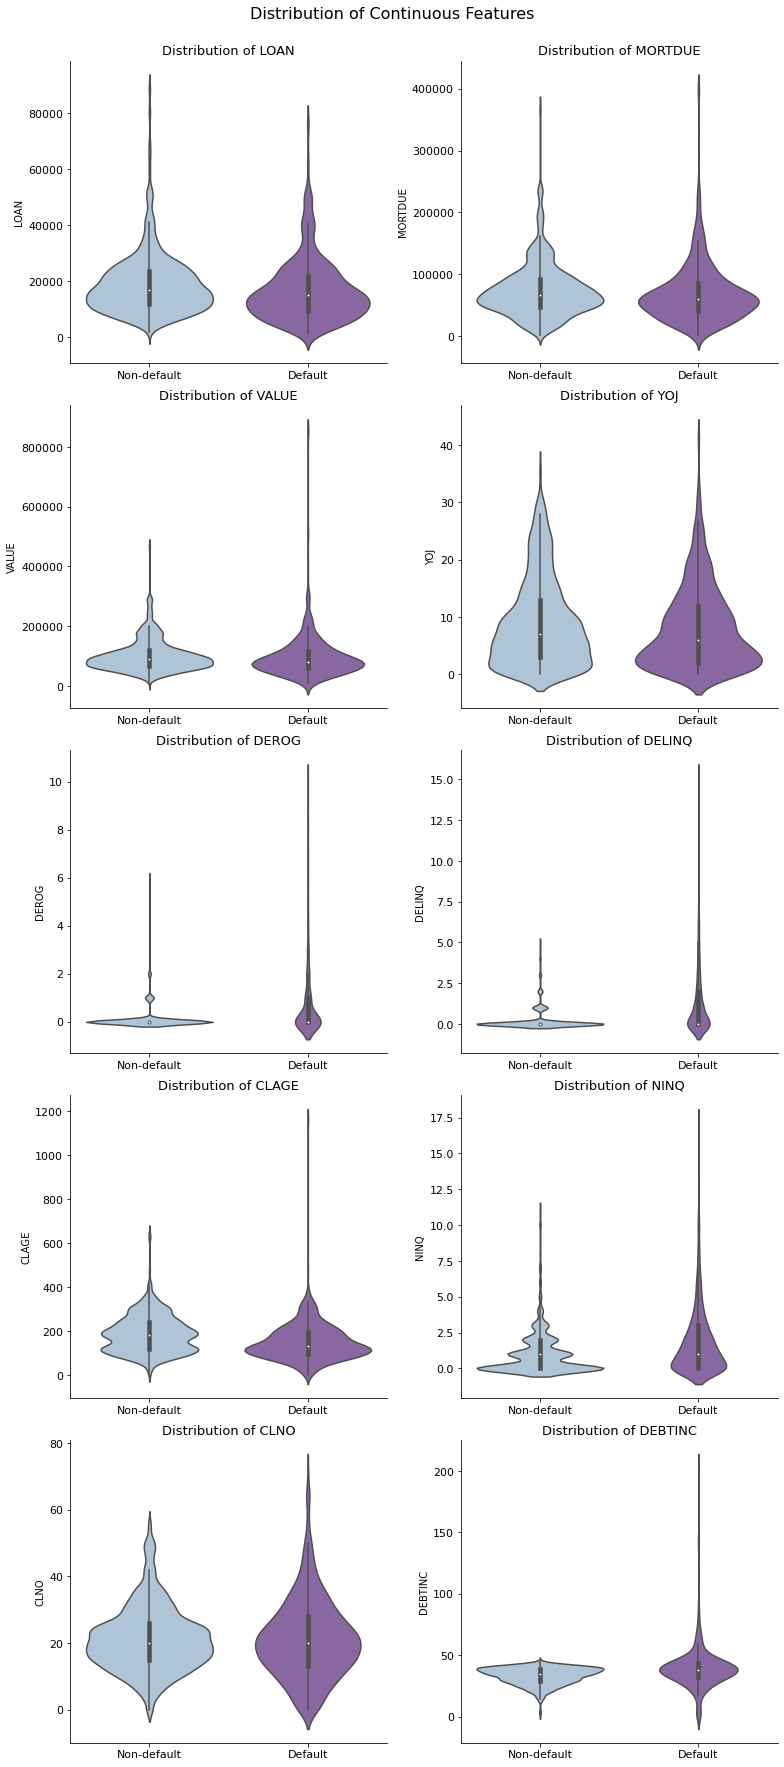

In [85]:
continuous_distribution_plot(data, cont_vars, plot_type = 'violinplot',
                             export = True)

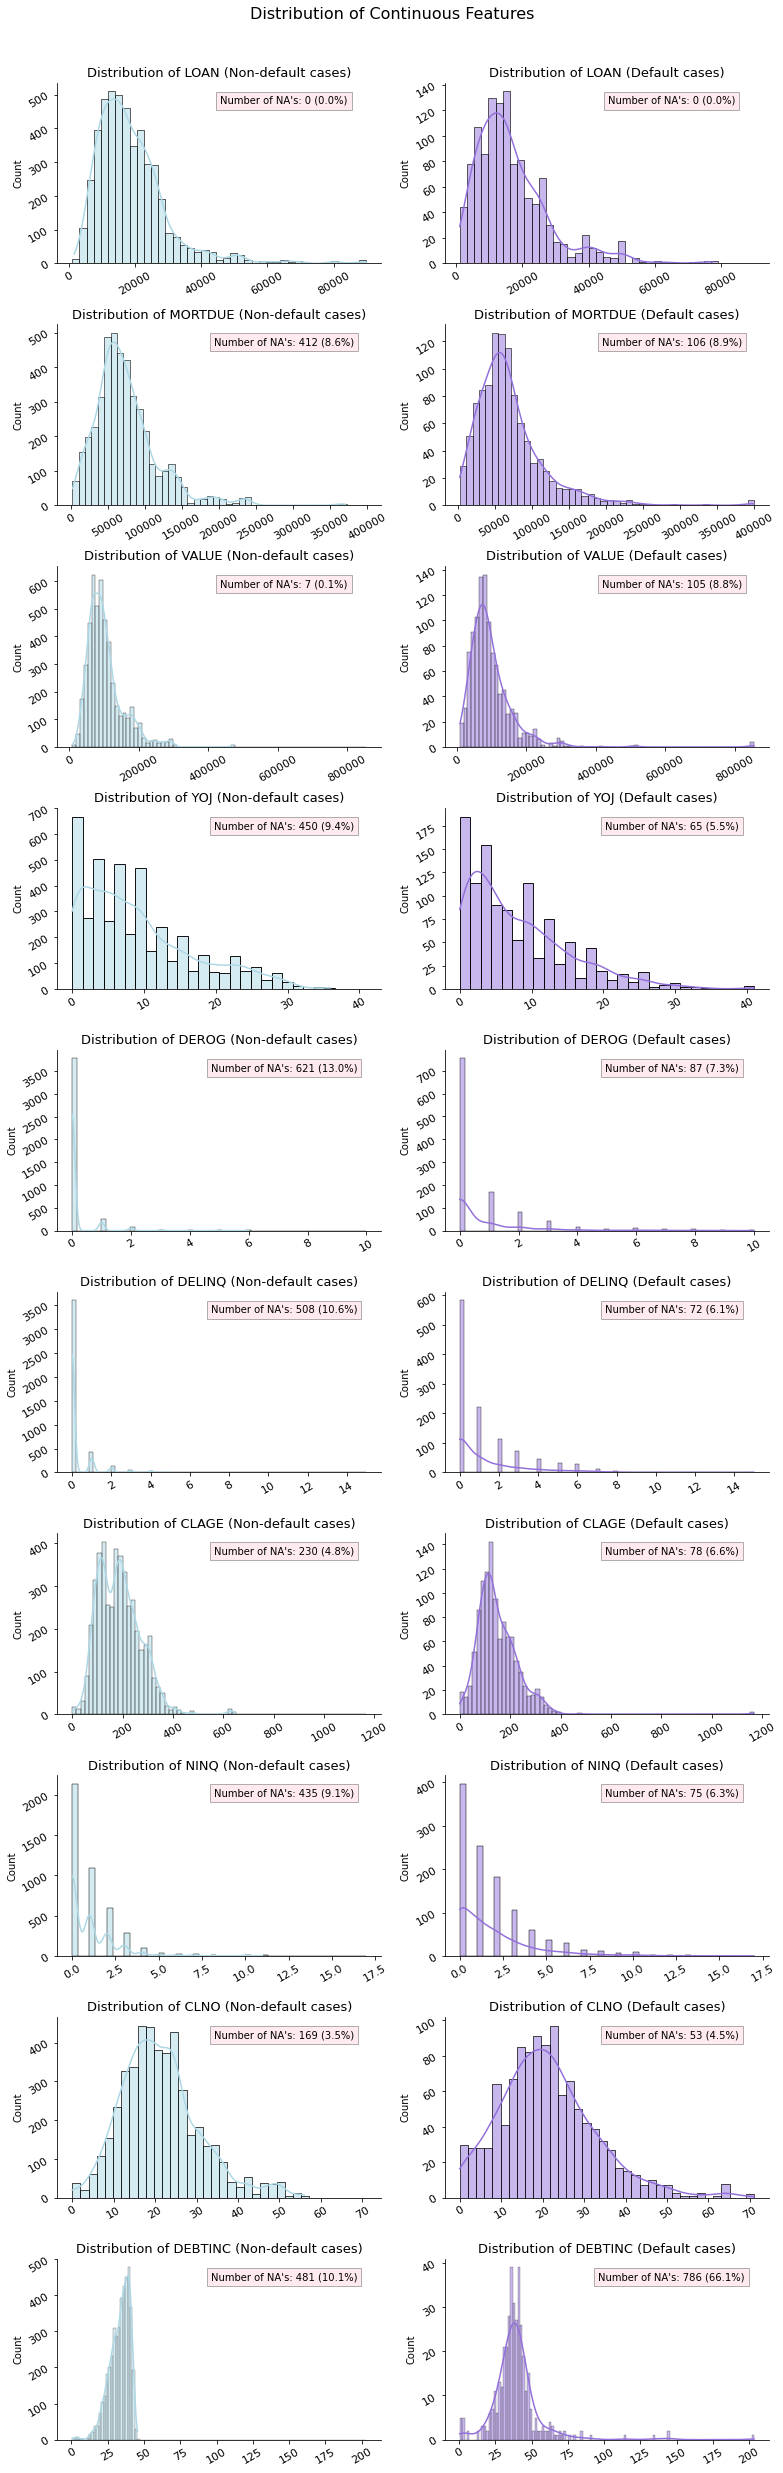

In [86]:
continuous_distribution_plot(data, cont_vars, plot_type = 'histogram',
                             export = True)

In [87]:
def categorical_distribution_plot(df: pd.DataFrame, cat_vars: list,
                                  target: str = 'BAD', export: bool = False):
    
    #Figure's and axes' initialization
    fig, axs = plt.subplots(nrows = len(cat_vars),ncols = 2, figsize = (11, 9))

    #Column index
    col_ind = 0
    #Axis index (if the value is even, the plot will be located on the left side, otherwise on the right side)
    axis_count = 0

    for ax in axs.ravel():

        #Accessing the feature name
        var = cat_vars[col_ind]
        #Subsetting the data based on the feature with subsequent replacing missing values with N/A's strings (for visualization's sake).
        var_target_df = df[[var, target]].copy().fillna('N/A')
        
        #If the feature has some missing values, put the N/A category at the end of the plot.
        if var_target_df.query(f'{var} == "N/A"').shape[0] != 0:
            categories = [cat for cat in var_target_df[var].unique() if cat != 'N/A'] + ['N/A']
        else:
            categories = var_target_df[var].unique()

        #The left side (even axis_count) depicts the features' distribution conditional on the non-default cases.
        if axis_count % 2 == 0:

            sns.countplot(data = var_target_df.query(f'{target} == 0'), x = var,
                          ax = ax, order = categories, color = 'lightblue')

            ax.set_title(f"Distribution of {var} (Non-default cases)", size = 13)
            ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
            ax.set(xlabel = None)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
                        
        
        #The right side (odd axis_count) depicts the features' distribution conditional on the default cases.
        else:
            
            sns.countplot(data = var_target_df.query(f'{target} == 1'), x = var,
                          ax = ax, order = categories, color = 'mediumpurple')

            ax.set_title(f"Distribution of {var} (Default cases)", size = 13)
            ax.tick_params(axis = 'both', which = 'major', labelsize = 11)
            ax.set(xlabel = None)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            #Proceeding with the next feature
            col_ind += 1

        #Switching to the left/right side of the figure
        axis_count += 1

    plt.tight_layout()


    fig.suptitle("Distribution of Categorical Features", fontsize = 16)
    fig.subplots_adjust(top=0.90)

    #Exporting the plots
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Categorical_Features_Distribution.jpg', dpi = 1200)
        
    plt.show()

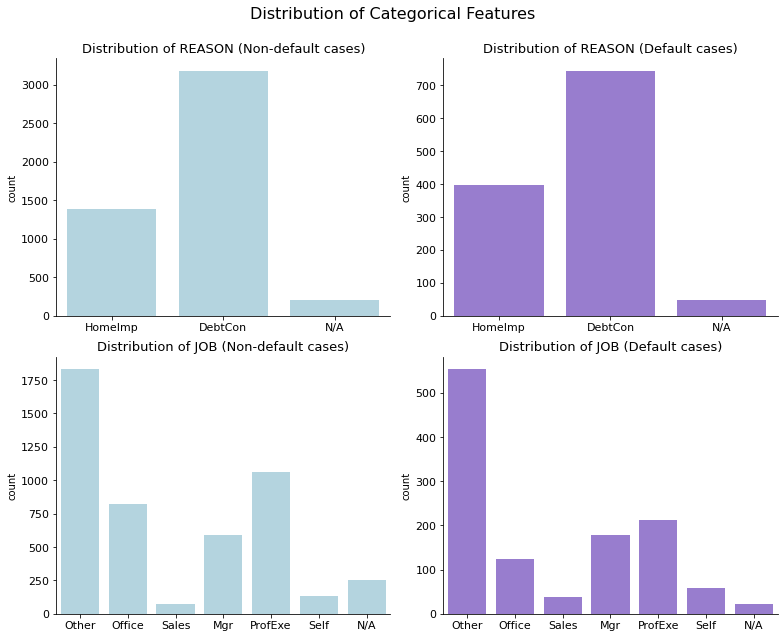

In [88]:
categorical_distribution_plot(data, cat_vars, export = True)

In [89]:
def spearman_corr_matrix_plot(df: pd.DataFrame, cont_vars: list, export: bool = False):

    #Figure's initialization
    plt.figure(figsize = (12,12))

    #Corelation matrix heatmap
    sns.heatmap(df[cont_vars].corr(method = 'spearman'), vmin = -1, vmax = 1,
                mask = np.triu(np.ones_like(df[cont_vars].corr())),
                annot = True, cmap  = 'coolwarm',  fmt = '.3f')
            
    plt.title('Spearmen Correlation Matrix of Continuous Features', size = 15)

    plt.tight_layout()

    #Exporting the plots
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Spearman_Correlation_Matrix_Continuous_Features.jpg', dpi = 1200)
    
    plt.show()

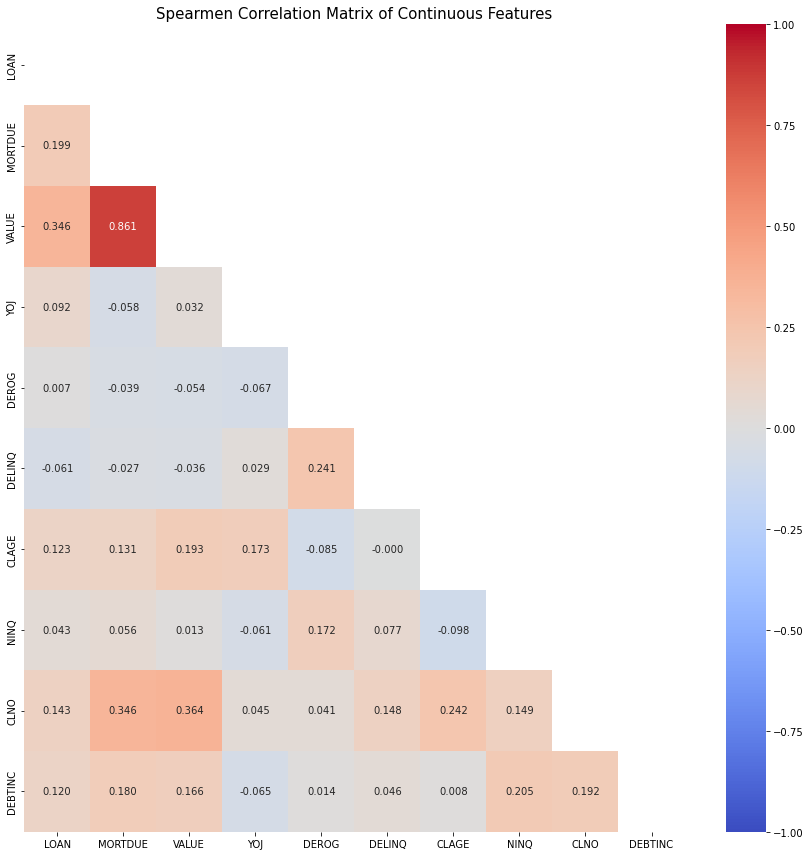

In [90]:
spearman_corr_matrix_plot(data, cont_vars, export = True)

In [91]:
def pointbiserial_corr_plot(df: pd.DataFrame, cont_vars: list,
                            target: str = 'BAD', export: bool = False):

    coef_name = 'Point Biserial coefficient'

    pointbis_corrs_df = pd.DataFrame(columns = [coef_name], index = cont_vars)

    for cont in cont_vars:

        filtered_df = df[df[cont].notna()]
        pointbis_corr = pointbiserialr(filtered_df[target], filtered_df[cont])[0]
        pointbis_corrs_df.loc[cont, coef_name] = pointbis_corr

    pointbis_corrs_df = pointbis_corrs_df.astype('float64')

    plt.figure(figsize = (3, 5))
    sns.heatmap(pointbis_corrs_df, vmin = -1, vmax = 1, annot = True, cmap  = 'coolwarm', fmt = '.3f')
    plt.title('Point Biserial Correlation between \n the Continuous Features and Default', size = 13)
    plt.tight_layout()
 
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Point_Biserial_Correlation_Continuous_Features_Default.jpg', dpi = 1200)
    plt.show()

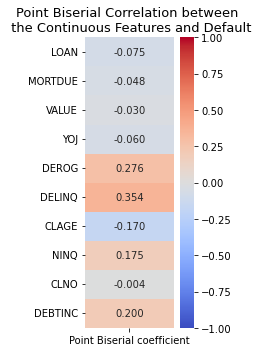

In [92]:
pointbiserial_corr_plot(data, cont_vars, export = True)

In [93]:
def matthews_corr_feat_na_plot(df: pd.DataFrame, target: str = 'BAD', export: bool = False):

    df_ = df.drop(target, axis = 1).copy()
    
    matthews_contna_df = pd.DataFrame(columns = df_.columns, index = df_.columns)


    for cont1 in df_.columns:
        temp = df_.drop(cont1, axis = 1)
        if df_[cont1].dtypes == 'O':
            bool_var_nas_1 = [1 if type(i) != type('') else 0 for i in df_[cont1]]
        else:
            bool_var_nas_1 = [1 if math.isnan(i) == True else 0 for i in df_[cont1]]
        for cont2 in temp.columns:
            if temp[cont2].dtypes == 'O':
                bool_var_nas_2 = [1 if type(i) != type('') else 0 for i in temp[cont2]]
            else:
                bool_var_nas_2 = [1 if math.isnan(i) == True else 0 for i in temp[cont2]]
            matth_corr = matthews_corrcoef(bool_var_nas_1, bool_var_nas_2)
            matthews_contna_df.loc[cont1, cont2] = matth_corr

    matthews_contna_df = matthews_contna_df.astype('float64')
    matthews_contna_df.index = [f'{col}_IS_NA' for col in df_.columns]
    matthews_contna_df.columns = [f'{col}_IS_NA' for col in df_.columns]

    plt.figure(figsize = (15, 15))
    sns.heatmap(matthews_contna_df, vmin = -1, vmax = 1, annot = True, fmt = '.3f',
                mask = np.triu(np.ones_like(matthews_contna_df)), cmap  = 'coolwarm')
    
    plt.title("Matthews correlation between the missing observations of Continuous Features", size = 13)
        #Exporting the plots
    plt.tight_layout()
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Matthews_Correlation_NA_Features.jpg', dpi = 1200)

    plt.show()

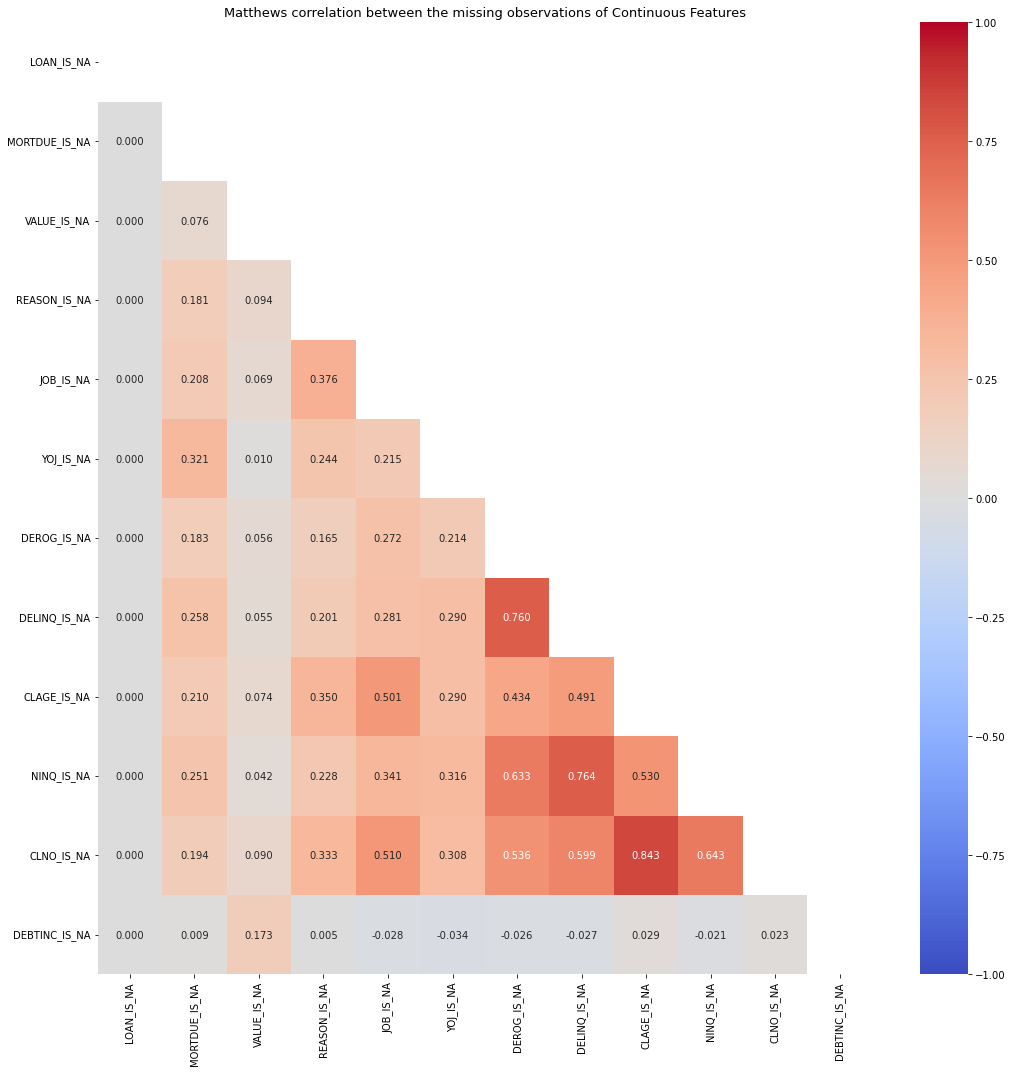

In [94]:
matthews_corr_feat_na_plot(data, export = True)

In [95]:
def matthews_corr_contna_default_plot(df: pd.DataFrame, cont_vars: list, target: str = 'BAD'):

    coef_name = 'Matthews coefficient'

    matthews_contna_default_df = pd.DataFrame(columns = [coef_name], index = cont_vars)

    for cont in cont_vars:
        bool_var_nas = [1 if math.isnan(i) == True else 0 for i in df[cont]]
        matth_corr = matthews_corrcoef(df[target], bool_var_nas)
        matthews_contna_default_df.loc[cont, coef_name] = matth_corr

    matthews_contna_default_df = matthews_contna_default_df.astype('float64')
    matthews_contna_default_df.index = [f'{col}_IS_NA' for col in cont_vars]

    plt.figure(figsize = (2, 5))
    sns.heatmap(matthews_contna_default_df, vmin = -1, vmax = 1, annot = True, fmt = '.3f', cmap  = 'coolwarm', cbar_kws={'shrink': 0.90})
    plt.title('Matthews Correlation between \n the missing occurences of Continuous Features and Default', size = 13)
    plt.show()

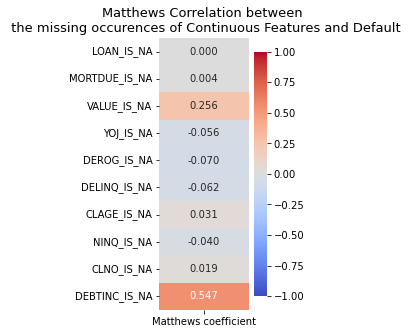

In [96]:
matthews_corr_contna_default_plot(data, cont_vars)

In [97]:
def data_split(df: pd.DataFrame, test_size: float,
               validation_size: float, seed: int,
               oversampling: bool = False,
               target: str = 'BAD') -> tuple[pd.DataFrame, pd.Series,
                                             pd.DataFrame, pd.Series,
                                             pd.DataFrame, pd.Series]:
    
    #Separating the target variable (Y) and the features (X)
    Y = df[target]
    X = df.drop(target, axis = 1)

    #Stratified split into training set, validation set and test set
    X_temp, X_test, y_temp, y_test = train_test_split(X, Y, stratify = Y, test_size = test_size, random_state = seed)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, stratify = y_temp, test_size = validation_size, random_state = seed)

    #Optional SMOTE oversampling of the training set.
    if oversampling:
        
        #indices of categorical variables
        cat_vars_ind = [ind for ind, i in enumerate(X_train.columns) if X_train[i].dtypes == 'O']
        cat_vars = X_train.columns[cat_vars_ind]
        cont_vars = [col for col in X_train.columns if col not in cat_vars]

        #SMOTE initialization
        smote = SMOTENC(random_state = seed, categorical_features = cat_vars_ind)
        
        #Temporary imputing of missing values (separately for categorical and continuous features)
            #SMOTE cannot work with NA's, thus we replace them with arbitrary values.
        X_train_imputed = pd.concat((X_train[cat_vars].copy().fillna('NAN'),
                                     X_train[cont_vars].copy().fillna(99999999999999)),
                                    axis = 1)[X_train.columns]

        #Fitting the SMOTE
        X_train_final, y_train_final = smote.fit_resample(X_train_imputed, pd.DataFrame(y_train).astype('int64'))

        #Replacing the NA's strings back to NA's with respect to the categorical features.
        X_train_final = X_train_final.replace({'NAN': np.nan})

        #Replacing back the missing values (99999999999999) with NA's in such case whether the value is exceeding the maximum value of given continuous feature before imputing.
        for cont in cont_vars:
            max_value = X_train[cont].max()
            X_train_final[cont] =  X_train_final[cont].apply(lambda x: np.nan if x > max_value else x) 

        #Convert target from Data Frame to Series
        y_train = y_train_final['BAD']

        return  X_train_final, y_train_final, X_valid, y_valid, X_test, y_test

    else:
        return X_train, y_train, X_valid, y_valid, X_test, y_test

In [98]:
X_train, y_train, X_valid, y_valid, X_test, y_test = data_split(data, test_size, validation_size, seed)

In [99]:
def print_data_info(**kwargs):
    
    for name, x_set in kwargs.items():

        no_dashes = 35
        no_dashes_name_left = int((no_dashes - len(name) - 1)/2)*"-"
        no_dashes_name_right  = f"{(no_dashes - len(name) - len(no_dashes_name_left) - 2)*'-'}"
        data_info = f'{x_set.shape[0]} instances, {x_set.shape[1]} features'
        no_spaces_data_info_left = int((no_dashes - len(data_info) - 1)/2)*"-"
        no_spaces_data_info_right = f'{(no_dashes - len(data_info) - len(no_spaces_data_info_left) - 2)*"-"}'
        
        print(no_dashes*'-')
        print(f'{no_dashes_name_left} {name} {no_dashes_name_right}')
        print(f'{no_spaces_data_info_left} {data_info} {no_spaces_data_info_right}')
        print(no_dashes*'-', '\n')

In [100]:
print_data_info(Training = X_train, Validation = X_valid, Test = X_test)

-----------------------------------
------------- Training ------------
--- 4171 instances, 12 features ---
----------------------------------- 

-----------------------------------
------------ Validation -----------
---- 895 instances, 12 features ---
----------------------------------- 

-----------------------------------
--------------- Test --------------
---- 894 instances, 12 features ---
----------------------------------- 



In [101]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4171 entries, 2353 to 1114
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   LOAN     4171 non-null   int64  
 1   MORTDUE  3801 non-null   float64
 2   VALUE    4099 non-null   float64
 3   REASON   3987 non-null   object 
 4   JOB      3969 non-null   object 
 5   YOJ      3803 non-null   float64
 6   DEROG    3679 non-null   float64
 7   DELINQ   3766 non-null   float64
 8   CLAGE    3945 non-null   float64
 9   NINQ     3804 non-null   float64
 10  CLNO     4008 non-null   float64
 11  DEBTINC  3292 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 423.6+ KB


In [234]:
def woe_binning(x_train_set: pd.DataFrame, y_train_labels: pd.Series,
                cat_vars: list, save_binning_woe_model: bool = True,
                **kwargs) -> tuple[dict, pd.DataFrame]:

    """
    Function for binning the variables optimally with respect to the target variable
            - based on implementation of a rigorous and flexible mathematical programming formulation.
        - It is fitted on  training set, based on which it transforms both training and holdout set,
            - with binning (grouping) the categories for each variable.
        - Subsequently, all the categories are transformed to the numerical values, using the Weight-of-Evidence
            - (which is fitted from the training set as well).
        - The output also includes a data frame which stores all the information about the binned categories,
            - (such as grouped categories names, event rate, WoE etc.) for each variable.
    Arguments:
        x_train_set - Data frame of features used for training the model.
        y_train_labels - Data frame or Series of labels used for training the model.
        x_holdout_set - Data frame of features which is not used in the training the model (for instance, Validation set or Test set of features).
        cat_vars - List of the categorical features in x_train_set.
        save_binning_woe_model - True if we want to export the fitted Binning object in h5 format, otherwise False.
    Outputs (3 outputs):
        x_train_binned - Transformed training set of features with the binned categories which are transformed into WoE values.
        x_holdout_set_binned - Transformed Validation/Test set of features with the binned categories which are transformed into WoE values.
                                - (based on the fitted Binning object on training set).
        woe_bins - Data frame which contains information about binned features' categories
                    - (including WoE values, number of events/non-events, category frequencies etc.).
    """

    binning_path = '/feature_preprocessing/'

    #Initializing the binning process object.
    bn = BinningProcess(variable_names = list(x_train_set.columns), categorical_variables = cat_vars)

    #Fitting the binning on training set.
    bn.fit(x_train_set, y_train_labels)

    #DataFrame including binned categories' information.
    bins_woe = pd.DataFrame()

    for i in x_train_set.columns:
        
        var = bn.get_binned_variable(i).binning_table.build()
        var = var[(~var['Bin'].isin(['Special'])) & (~var.index.isin(['Totals']))]
        var['Variable'] = i

        bins_woe = pd.concat((bins_woe, var))

    bins_woe = bins_woe.loc[:, ~bins_woe.columns.isin(['IV','JS'])]
        
    if save_binning_woe_model:
        os.makedirs(binning_path, exist_ok = True)
        bn.save(f'{binning_path}binning_woe_model.h5')

    #Transforming both training set and test set based on the fitted training binning.
    def woe_bin_transform(bn_fit, x_set):
        x_set_binned = bn_fit.transform(x_set, metric = 'woe')
        x_set_binned.index = x_set.index
        
        return x_set_binned
    
    X_binned_sets = {'X_train_binned': woe_bin_transform(bn, x_train_set)}
    x_set_copy = X_binned_sets['X_train_binned'].copy()

    for col in x_set_copy.columns:
        na_woe = bins_woe.query('Variable == @col and Bin == "Missing"')['WoE'].values[0]
        x_set_copy.loc[x_train_set[col].isna(), col] = na_woe
    X_binned_sets['X_train_binned'] = x_set_copy

    for name, x_set in kwargs.items():
        X_binned_sets[f'{name}_binned'] = woe_bin_transform(bn, x_set)
        x_set_copy = X_binned_sets[f'{name}_binned'].copy()
        for col in x_set_copy.columns:
            na_woe = bins_woe.query('Variable == @col and Bin == "Missing"')['WoE'].values[0]
            x_set_copy.loc[x_set[col].isna(), col] = na_woe
        X_binned_sets[f'{name}_binned'] = x_set_copy

    return (X_binned_sets, bins_woe)

In [235]:
X_binned_sets, woe_bins = woe_binning(X_train, y_train, cat_vars, X_valid = X_valid, X_test = X_test)

In [104]:
X_train_binned, X_valid_binned, X_test_binned = (x_set for _, x_set in X_binned_sets.items())

In [105]:
X_train_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
2353,0.021652,0.271560,0.312694,0.060674,0.227974,-0.344280,0.208984,0.442888,-0.177086,0.269463,0.172234,-1.051481
4593,0.294660,-0.423990,-3.787489,0.060674,-0.660856,-0.344280,-1.315486,0.442888,0.323603,0.269463,0.172234,-1.845570
2110,0.021652,0.072519,0.072874,0.060674,0.227974,0.093742,0.208984,-0.867265,0.846376,0.093061,0.127892,1.569097
2346,0.021652,-0.003300,-0.930062,0.060674,-0.179486,0.093742,0.565640,0.547877,-0.567830,-0.252955,-0.722519,1.279616
4539,0.294660,0.271560,1.185559,0.060674,0.227974,0.093742,0.208984,0.442888,0.362160,0.269463,0.532218,-1.051481
...,...,...,...,...,...,...,...,...,...,...,...,...
2066,0.021652,-0.423990,0.072874,0.060674,-0.213595,0.483777,0.565640,0.547877,-0.255264,0.411735,-0.092912,1.146451
2981,0.171642,-0.029859,0.072874,0.060674,0.227974,-0.225287,0.208984,0.442888,0.719945,-0.252955,-0.044543,1.279616
1785,0.021652,0.271560,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,-0.252955,0.172234,1.146451
5063,0.294660,-0.029859,0.072874,0.060674,-0.179486,0.093742,0.208984,0.442888,-0.177086,0.093061,0.172234,-1.051481


In [106]:
X_valid_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
743,-0.216081,-0.393497,0.072874,-0.147881,0.402165,0.658815,0.208984,0.442888,0.846376,0.093061,0.127892,1.146451
3192,0.303481,-0.423990,0.072874,0.060674,-0.179486,-0.344280,0.208984,0.442888,0.362160,0.269463,-0.722519,1.146451
3214,0.303481,0.072519,-3.787489,0.060674,0.402165,0.658815,0.208984,0.442888,-0.003300,0.093061,0.172234,1.279616
3383,0.303481,0.072519,0.312694,-0.147881,0.227974,0.658815,0.208984,0.442888,0.362160,0.269463,0.532218,1.146451
2042,0.021652,0.072519,0.312694,-0.147881,0.227974,0.093742,0.208984,0.442888,0.719945,0.093061,0.127892,-1.845570
...,...,...,...,...,...,...,...,...,...,...,...,...
1686,0.021652,0.271560,0.312694,-0.147881,-0.213595,0.093742,0.208984,0.442888,0.719945,0.269463,0.532218,1.569097
4822,0.294660,0.072519,0.312694,0.060674,0.402165,-0.344280,0.208984,0.442888,-0.567830,0.269463,0.172234,1.146451
2806,0.171642,0.271560,0.312694,0.060674,-0.213595,-0.225287,0.565640,0.547877,0.362160,-0.252955,-0.482873,1.146451
4056,0.909413,-0.029859,0.072874,0.060674,-0.179486,0.093742,0.208984,0.442888,-0.567830,-0.252955,0.172234,1.146451


In [107]:
X_test_binned

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
2120,0.021652,-0.423990,0.072874,0.060674,-0.213595,0.483777,0.565640,0.547877,-0.255264,0.411735,-0.092912,1.146451
2296,0.021652,0.072519,0.072874,0.060674,1.287203,0.093742,0.565640,0.547877,-0.255264,0.411735,-0.092912,1.505042
688,-0.216081,0.072519,0.312694,-0.147881,0.227974,-0.225287,0.208984,0.442888,0.362160,-0.252955,0.532218,1.569097
4508,0.294660,0.271560,-0.134034,-0.147881,-0.213595,-0.225287,0.208984,0.442888,0.362160,0.269463,0.127892,1.279616
467,-0.216081,-0.029859,0.072874,0.060674,1.287203,-0.225287,0.208984,0.442888,0.362160,-0.361934,-0.044543,1.569097
...,...,...,...,...,...,...,...,...,...,...,...,...
1926,0.021652,-0.682654,-0.184271,-0.147881,-0.179486,0.093742,0.208984,0.442888,-0.567830,0.269463,-0.722519,1.146451
3340,0.303481,0.072519,0.072874,0.060674,-0.179486,-0.344280,0.208984,0.442888,0.846376,-0.361934,0.172234,0.883138
2939,0.171642,0.271560,0.312694,0.060674,0.402165,-0.344280,0.565640,0.547877,-0.293054,-0.252955,0.172234,1.279616
5287,0.294660,-0.682654,-0.184271,0.060674,-0.179486,0.658815,0.208984,0.442888,0.846376,0.269463,0.532218,1.146451


In [108]:
def prep_data_export(features: tuple, labels: tuple,
                     ind_sets: tuple = ('Training', 'Validation', 'Test'),
                     csv_name:str = '') -> pd.DataFrame:

    """

    Function for joining the X train/validation/test sets of features and y train/validation/y test sets of labels into a single data frame.
     - Optionally, it can also export this joined data set into csv file.

    Arguments:
        features - tuple of data frames of features ... e.g., [X_train, X_valid, X_test]
        labels - tuple of series or data frames of labels ... e.g., [y_train, y_valid, y_set]
        ind_sets - tuple of sets names ... e.g., ['Training', 'Validation', 'Test']
                    - this will distinguish the instances in the data frame (which instance belongs to training set etc.)
        export - True if we want to export the joined data set into csv format, otherwise False
        csvname - The name of the csv file.
    
    Output:
        Data frame - which do have joined Training/Validation/Test features and labels.

    """

    df_list = []
    
    #Join each pair of features and labels data, assign to it a set indicator,
        # append to the list and then,
        #  transform that list into a data frame (and export it).
    for feat, lab, ind in zip(features, labels, ind_sets):
        
        temp = pd.concat((lab, feat), axis = 1)
        temp['set'] = ind
        df_list.append(temp)
    
    dfs = [df for df in df_list]

    final_df = pd.concat(dfs, axis = 0).sort_index()

    if len(csv_name) != 0:
        os.makedirs('./data/', exist_ok = True)
        final_df.to_csv(f'./data/{csv_name}.csv', index = False)
    
    return final_df

In [109]:
interim = prep_data_export((X_train_binned, X_valid_binned, X_test_binned),
                            (y_train, y_valid, y_test),
                            ('Training', 'Validation', 'Test'),
                            csv_name = 'interim_data')

In [110]:
interim

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,set
0,1,-1.339163,-0.682654,-0.930062,-0.147881,-0.179486,0.093742,0.208984,0.442888,-0.293054,0.093061,-0.722519,-1.845570,Training
1,1,-1.339163,0.072519,0.072874,-0.147881,-0.179486,0.093742,0.208984,-0.867265,-0.293054,0.269463,0.127892,-1.845570,Test
2,1,-1.339163,-0.393497,-0.930062,-0.147881,-0.179486,-0.225287,0.208984,0.442888,-0.177086,0.093061,0.127892,-1.845570,Validation
3,1,-1.339163,-0.003300,-3.787489,0.131178,1.287203,0.483777,0.565640,0.547877,-0.255264,0.411735,-0.092912,-1.845570,Training
4,0,-1.339163,0.271560,0.312694,-0.147881,0.402165,-0.344280,0.208984,0.442888,-0.293054,0.269463,0.127892,-1.845570,Training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,-0.321287,0.072519,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,0.269463,0.172234,1.146451,Training
5956,0,-0.321287,-0.029859,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,0.269463,0.172234,1.146451,Training
5957,0,-0.321287,-0.029859,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,0.269463,0.172234,1.146451,Test
5958,0,-0.321287,-0.029859,0.312694,0.060674,-0.179486,0.093742,0.208984,0.442888,0.362160,0.269463,0.172234,1.279616,Training


In [111]:
def woe_bins_plot(bins_woe: pd.DataFrame, export: bool = False):

    """
    Function for plotting the WoE values of each features' categories.
    
    Arguments:
        bins_woe - Data frame which contains information about binned features' categories (including WoE values).
    
    Output:
        Plot containing WoE distribution of features' categories.
    
    """

    fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 25))
    

    for i, ax in zip(bins_woe['Variable'].unique(), axs.ravel()):
    
        temp = bins_woe.loc[bins_woe['Variable'] == i]
        sns.barplot(x = temp.index, y = 'WoE', data = temp, ax = ax, palette = "BuPu")
        ax.axhline(y = 0, color = 'black', linewidth = 1)
        
        cat = False

        for j in temp['Bin']:
            if isinstance(j, np.ndarray):
                cat = True
                break
        if cat == False:
            labels = list(temp['Bin'])
 
        elif cat == True:
            labels = [k if type(k) == type('Missing') else str(list(k)).replace('[','').replace(']','').replace("'",'') for k in temp['Bin']]
        
        ax.set_title(i, size = 13)
        ax.set_xticklabels(labels, rotation = 90, size = 11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    

    fig.tight_layout()

    fig.suptitle("WoE coefficients' Distribution per Features", fontsize = 16)
    fig.subplots_adjust(top=0.95)
    
    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/WoE_Distribution.jpg', dpi = 1200)

    plt.show()

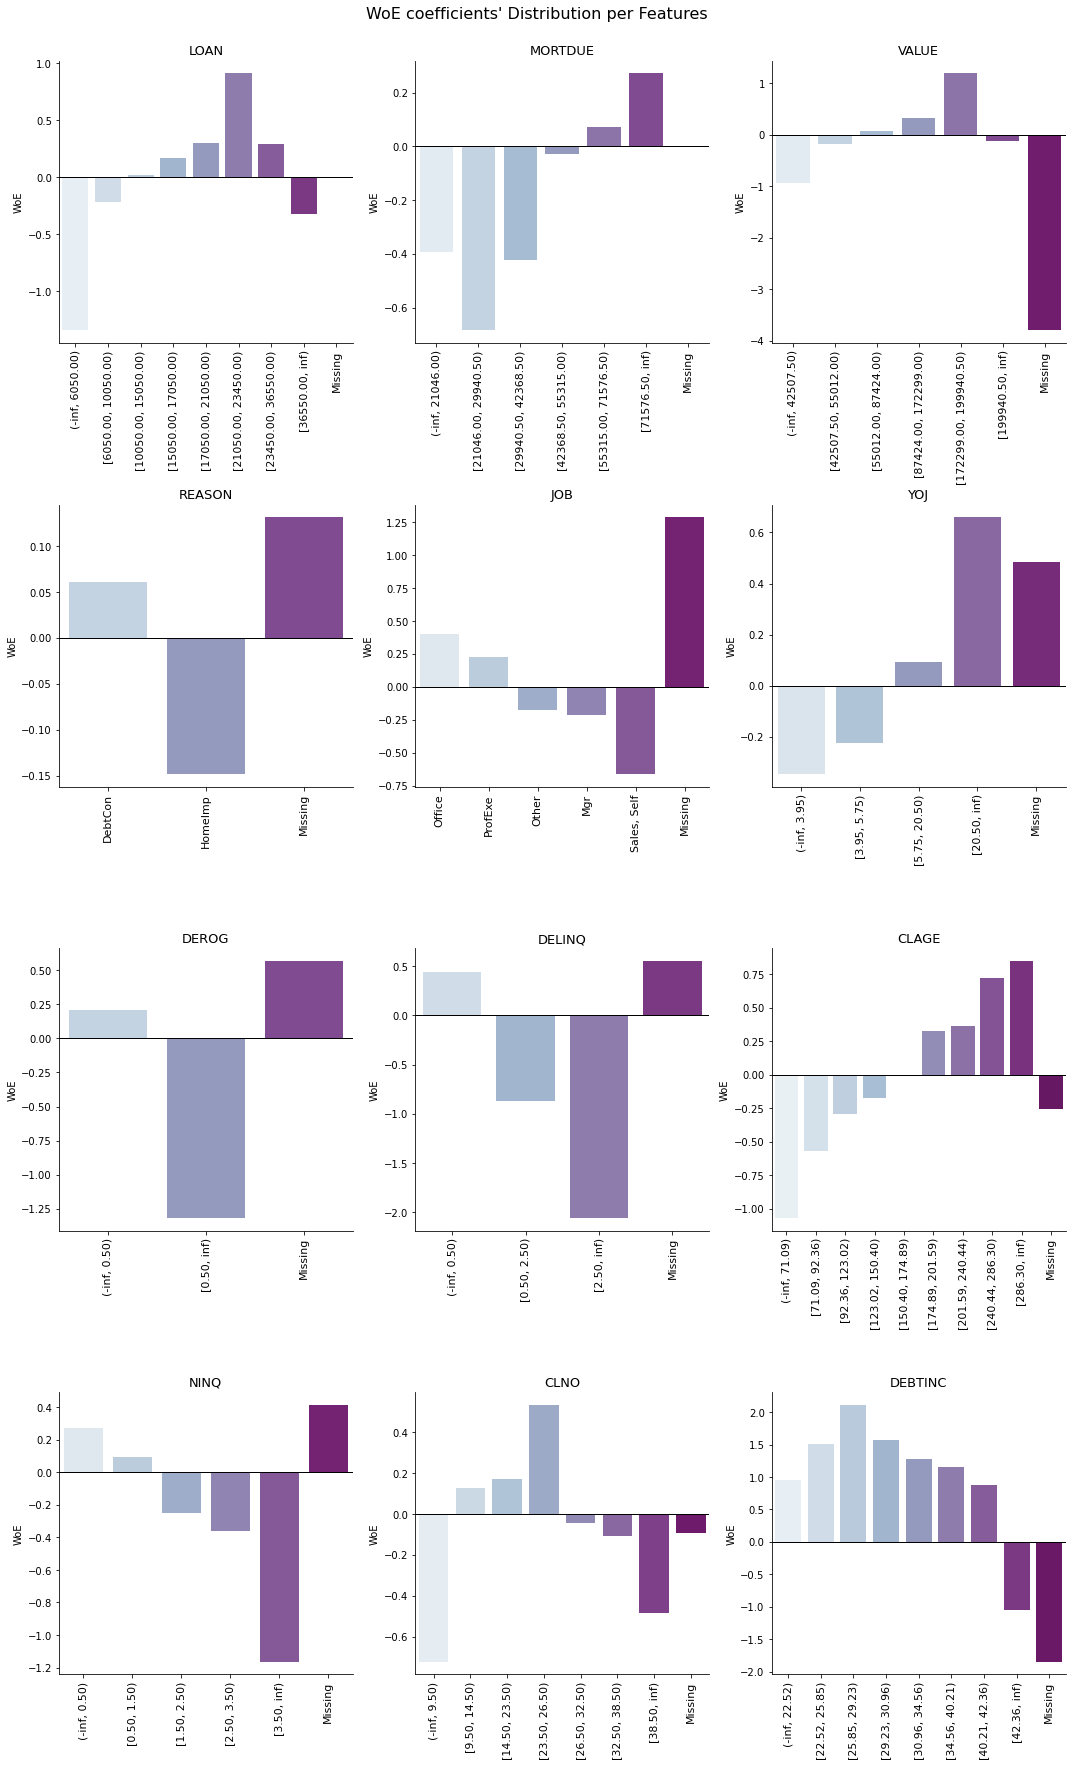

In [112]:
woe_bins_plot(woe_bins, export = True)

In [ ]:
models_dict = {
               'Logistic Regression': LogisticRegression(random_state = seed, n_jobs = -1),
               'Gaussian Naive Bayes': GaussianNB(),
               'K Neighbors Classifier': KNeighborsClassifier(n_jobs = -1),
               'Decision Tree Classifier': DecisionTreeClassifier(random_state = seed),
               'Random Forest Classifier': RandomForestClassifier(random_state = seed, n_jobs = -1),
               'Gradient Boosting Classifier': GradientBoostingClassifier(random_state = seed),
                'Support Vector Classifier': SVC(probability = True, random_state = seed),
                'Multi Layer Percepton Classifier': MLPClassifier(random_state = seed)
              }

"""
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard
import visualkeras
from keras.models import Model

class MyHyperModel(kt.HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        input_layer = Input(shape=self.input_shape)
        x = input_layer
        # Define hyperparameters for the number of dense layers and their units
        num_layers = hp.Int('number_of_layers', min_value = 1, max_value = 10)

        for i in range(num_layers):
            units = hp.Int(f'Dense_units_{i}', min_value = 10,
                                max_value = 360, step = 10, default = 50)
        
            activations = hp.Choice(f'activation_{i}', ['relu','tanh'])

            x = Dense(units = units, activation = activations)(x)

        
        output_layer = Dense(1, activation = 'sigmoid')(x)
        model = Model(input_layer, output_layer)

        # Define hyperparameters for the optimizer
        optimizer = hp.Choice('optimizer', values = ['adam', 'sgd','rmsprop'])
        if optimizer == 'adam':
            model.compile(optimizer = keras.optimizers.Adam(hp.Float('learning_rate',
                                                               min_value = 1e-4, max_value = 0.5,
                                                               sampling = 'log')),
                          loss = 'binary_crossentropy',
                          metrics = [tf.keras.metrics.Recall(name='recall')])
            
        elif optimizer == 'sgd':
            model.compile(optimizer = keras.optimizers.SGD(hp.Float('learning_rate',
                                                               min_value = 1e-4, max_value = 0.5,
                                                               sampling = 'log')),
                          loss = 'binary_crossentropy',
                          metrics = [tf.keras.metrics.Recall(name='recall')])
            
        else:
            model.compile(optimizer = keras.optimizers.RMSprop(hp.Float('learning_rate',
                                                               min_value = 1e-4, max_value = 0.5,
                                                               sampling = 'log')),
                          loss = 'binary_crossentropy',
                          metrics = [tf.keras.metrics.Recall(name='recall')])

        return model

input_shape = (len(X_train_binned.columns),)
hypermodel = MyHyperModel(input_shape=input_shape)

tuner = kt.BayesianOptimization(
    hypermodel,
    objective = kt.Objective("recall", direction="max"),
    max_trials=10,
    project_name='keras_opt'
)

best_hypers = tuner.get_best_hyperparameters(num_trials = 1)[0]

final_model = tuner.hypermodel.build(best_hypers)

final_model.fit(X_train_binned, y_train,
                          epochs = 15, verbose = 1,
                          )
"""

In [145]:
def bayesian_optimization(model, x_train:pd.DataFrame, y_train:pd.Series, seed:int):

    """

    This function tunes hyperparameters of a model using Bayesian Optimization while maximizing objective function F1 score.
        - It is tuned on the training set.
        - It is tuned using Stratified 10-fold Cross Validation.

    Arguments:
        model - the model itself with default hyperparameters.
        x_train - Data frame which contains features used for training the model.
        y_train - Data frame (or series) which contains labels for training the model.
        seed - Globally defined random seed in order to preserve the reproducibility.
        max_features_constraint - This argument needs to bet set to True when tuning model which has hypeparameter max_features
                                - It can raise a value error in hyperparameter tuning within selection of final model,...
                                        -  ... when max_features is higher than the number of features in the sample:
                                                - "ValueError: max_features must be in (0, n_features]"
                                        - This issue can occur when model A chooses 5 features in the feature selection,..
                                                - but when tuning model B on the sample having 5 features chosen by model B,..
                                                - during tuning the max_features can exceed the number of features.
                                        - Therefore, the max_features needs to be adjusted accordingly to the number of features within given sample.
    
    Output:
        Model with the tuned hyperparameters.

    """
    
    estimator = model

    #Adjustment of max_features hyperparameter within the final model selection.
    #max_features = 9 if max_features_constraint == False else len(x_train.columns)
    max_features = len(x_train.columns)

    #Defining a searching space of possible ranges of hyperparameters, given the model.
    if type(model) == type(RandomForestClassifier()):

        search_space = {
                        'n_estimators': Integer(100, 1000),
                        'criterion': Categorical(['gini', 'entropy', 'log_loss']),
                        'max_depth': Integer(1, 10),
                        'max_features': Integer(3, max_features),
                        'min_samples_leaf': Integer(1, 40),
                        'min_samples_split': Integer(2, 80),
                        'class_weight': Categorical(['balanced', 'balanced_subsample', None]),
                        'bootstrap': Categorical([True, False]),
                        }


    elif type(model) == type(GradientBoostingClassifier()):

        search_space = {
                        'n_estimators': Integer(100, 1000),
                        'loss': Categorical(['log_loss', 'exponential']),
                         'max_depth': Integer(1, 10),
                         "learning_rate":Real(0.0001, 0.2, prior='log-uniform'),
                         'min_samples_leaf': Integer(4, 40),
                         'max_features': Integer(3, max_features),
                         'criterion': Categorical(['friedman_mse', 'squared_error']),
                        'min_samples_leaf': Integer(1, 40),
                        'min_samples_split': Integer(2, 80)
                        }


    elif type(model) == type(LogisticRegression()):

        search_space = {
                        'fit_intercept':  Categorical([True, False]),
                        'C': Real(0.000001, 10, prior='log-uniform'),
                        'penalty': Categorical(['l1', 'l2', 'none', 'elasticnet']),
                        'solver': Categorical(['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']),
                        'class_weight': Categorical(['balanced', None])
                        }

# Add hyperparameters specific to each solver
        for solver in ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']:
            if solver == 'lbfgs' or solver == 'newton-cg':
        # Only 'l2' and 'none' penalties are supported for lbfgs and newton-cg solvers
                search_space['penalty'] = Categorical(['l2', 'none'])
            elif solver == 'sag':
                # Only 'l2' and 'elasticnet' penalties are supported for sag solver
                search_space['penalty'] = Categorical(['l2', 'elasticnet'])
                search_space['l1_ratio'] = Real(0, 1, prior='uniform')
            elif solver == 'liblinear':
             # All penalties are supported for liblinear solver
                search_space['penalty'] = Categorical(['l1', 'l2', 'none', 'elasticnet'])
                if search_space['penalty'] == 'l2':
                    search_space['dual'] = Categorical([True, False])
                if search_space['fit_intercept']:
                    search_space['intercept_scaling'] = Real(0.1, 100.0, prior='log-uniform')
            else:
        # 'saga' solver supports all penalties and l1_ratio hyperparameter
                search_space['penalty'] = Categorical(['l1', 'l2', 'none', 'elasticnet'])
                search_space['l1_ratio'] = Real(0, 1, prior = 'uniform')
                search_space['solver'] = Categorical(['saga'])


    elif type(model) == type(DecisionTreeClassifier()):
        
        search_space = {
                        'criterion': Categorical(['gini', 'entropy']),
                        'max_depth': Integer(1, 10),
                        'max_features': Integer(3, max_features),
                        'min_samples_leaf': Integer(4, 40)
                        }
    

    elif type(model) == type(GaussianNB()):

        search_space = {
                        'var_smoothing': Real(1e-9, 1e-6, prior='log-uniform')
                       }
    
    
    elif type(model) == type(KNeighborsClassifier()):

        search_space = {
                        'n_neighbors': Integer(1, 10),
                        'weights':  Categorical(['uniform', 'distance']),
                        'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
                        'leaf_size': Integer(10, 50),
                        'metric': Categorical(['minkowski', 'manhattan', 'euclidean', 'cityblock',  'l1', 'l2'])
                       }


    elif type(model) == type(SVC()):
        search_space = {
                        'C': Real(0.0001, 10, prior = 'log-uniform'),
                        'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree': Integer(1, 10),
                        'gamma': Categorical(['scale', 'auto']),
                        'shrinking': Categorical([True, False]),
                        'class_weight': Categorical(['balanced', None])
                       }

    
    elif type(model) == type(MLPClassifier()):
        search_space = {
                        'hidden_layer_sizes': Integer(10, 100),
                        'activation': Categorical(['logistic', 'identity', 'tanh', 'relu']),
                        'solver': Categorical(['lbfgs', 'sgd', 'adam']),
                        'learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
                        'learning_rate_init': Real(0.0001, 0.01, prior = 'log-uniform'),
                        'power_t': Real(0.1, 2, prior = 'log-uniform'),
                        'shuffle': Categorical([True, False]),
                        'momentum': Real(0.00001, 0.999999, prior = 'log-uniform'),
                        'nesterovs_momentum': Categorical([True, False]),
                        'early_stopping': Categorical([True, False]),
                        'beta_1': Real(0.00001, 0.999999, prior = 'log-uniform'),
                        'beta_2': Real(0.00001, 0.999999, prior = 'log-uniform'),
                        'epsilon': Real(1e-10, .09999999, prior = 'log-uniform'),
                        'alpha': Real(0.0001, 10, prior = 'log-uniform')
                       }
        
    
    #Initialization of the stratified 10-fold cross validation.
    stratified_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

    #Initialization of the Bayesian Optimization.
        # using the stratified 10-fold cross validation and given model, while maximizing the objective function recall score.
    bayescv = BayesSearchCV(estimator = estimator,
                            search_spaces = search_space,
                            scoring = "recall", cv = stratified_cv,
                            n_jobs = -1, n_iter = 50,
                            random_state = seed)

    #Fitting the Bayesian optimization algorithm on the training data.
    bayescv.fit(x_train, y_train)

    #Outputs the model with the best tuned hyperparameters with respect to Recall score.
    return bayescv.best_estimator_

In [146]:
def feat_selection(x_train:pd.DataFrame, y_train:pd.Series,
                   models_dict:dict, seed:int, export:bool = True) -> pd.DataFrame:

    """

    This function is used for feature selection using RFE which requires some model as an input.

    This function takes each model, tunes it hyperparameters using Bayesian Optimization with 10-fold Cross Validation.
                        - (defined in the previous step - tuned on the training set).
        - Then uses this tuned model for Recursive Feature Elimination (RFE) with 10-fold Cross Validation.
                        - in order to choose the optimal set of features (performed on the training set).
    
    If we have 4 models as an input, then we get 4 different sets of optimal features.

    Arguments:
        x_train - Data frame which contains features used for training the model.
        y_train - Data frame (or series) which contains labels for training the model.
        models_dict - Dictionary where the keys are model names and the values are the model objects with default hyperparameters.
        seed - Globally defined random seed in order to preserve the reproducibility.
    
    Output:
        Data frame:
            Columns:
                model_name - The name of the model (the model within the models_dict parameter)
                model - The model itself with the tuned hyperparameters which then has been used within RFE (feature selection)
                rfe_model - RFE object itself (when applying transform() method, it should transform given X set on X set with optimal features).
                n_features - Number of features selected by RFE.
                final_features - The list of features selected by RFE.
                execution_time - How long it takes to tune model's hyperparameters and choose the optimal features (in seconds).

    """
    opt_models_path = './models/feature_selection/opt_models/'
    feat_select_path = './models/feature_selection/feat_select_objects/'
    
    #Empty list for storing all the models with their tuned hyperparameters, number of features selected, and names of selected features.
    models_feats_list = []

    #For each model, tune its hyperparameters using Bayesian Optimization.
        # Then use the tuned model for feature selection using RFE while maximizing an objective function F1 Score.
    dashes = '-------------------------------------------------------------------------------------------------------------------'
    no_dashes = len(dashes)
    count = 1
    for name, mod in models_dict.items():
        
        print(dashes)
        order = f'{count}/{len(models_dict.keys())}'
        no_dashes_left = int((no_dashes - len(order) - 1)/2)*"-"
        no_dashes_right  = f"{(no_dashes - len(order) - len(no_dashes_left) - 2)*'-'}"
        print(f'{no_dashes_left} {order} {no_dashes_right}')
        print(dashes)

        text_ = f'FEATURE SELECTION WITH {name.upper()}'
        
        no_dashes_left_ = int((no_dashes - len(text_) - 1)/2)*"-"
        no_dashes_right_  = f"{(no_dashes - len(text_) - len(no_dashes_left_) - 2)*'-'}"
        print(f'{no_dashes_left_} {text_} {no_dashes_right_}')
        print(dashes)
        print(dashes, '\n')

        start = time.time()
        print(f'    1/4 ... Starting Bayesian Optimization of {name} on the whole set of features')

        opt_mod = bayesian_optimization(mod, x_train, y_train, seed)

        print(f'    2/4 ... Bayesian Optimization of {name} finished')

        #Initialization of the stratified 10-fold cross validation.
        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
        """
        #Adjustment of the min_features_to_select parameter within the RFE based on the tuned max_features hyperparameter
            # otherwise it would raise an error.
        if any("features" in s for s in opt_mod.get_params()):
            for par in list(opt_mod.get_params()):
                if re.search('features', par) != None:
                    num_feats = opt_mod.get_params()[par]
                    break
        else:
            num_feats = 1
        """
        
        print(f'    3/4 ... Starting Backward Sequential Feature Selection with {name}')

        #Initialization of the Recursive Feature Elimination 10-fold Cross Validation in order to select the optimal number of features
            # based on the model with tuned hyperparameters and maximizing F1 score function.
        sfs = SequentialFeatureSelector(mod, n_features_to_select='auto', direction = 'backward', scoring = 'recall', cv = cv, n_jobs = -1, tol = 0.0000001)
    
        sfs.fit(x_train, y_train)

        print(f'    4/4 ... Backward Sequential Feature Selection with {name} finished', '\n')
        end = time.time()

        #Extracting the final selected features and number of the selected features.
        selected_feats = x_train.columns[sfs.get_support()].tolist()
        number_features = len(selected_feats)
        
        print(f'    Execution time: {round(end - start)} seconds', '\n')
        print(f'    {number_features} features selected: {", ".join(selected_feats)}', '\n')
        print('-------------------------------------------------------------------------------------------------------------------')
        print('-------------------------------------------------------------------------------------------------------------------', '\n')
        print()
        
        if export:
            os.makedirs(opt_models_path, exist_ok = True)
            with open(f'{opt_models_path}FS_opt_{name.replace(" ", "")}.h5', 'wb') as opt_mod_save:
                pickle.dump(opt_mod, opt_mod_save)

            os.makedirs(feat_select_path, exist_ok = True)
            with open(f'{feat_select_path}SFS_w_{name.replace(" ", "")}.h5', 'wb') as feat_select_save:
                pickle.dump(sfs, feat_select_save)
        
        
        models_feats_list.append([name, opt_mod, sfs, number_features, selected_feats, end - start])
        count += 1
    
    #Storing all the models with their tuned hyperparameters, number of features selected, and names of selected features.
    feat_sel = pd.DataFrame(models_feats_list, columns = ['model_name', 'model', 'sfs_model',
                                    'n_features','final_features', 'execution_time'])
    
    if export:
        with open('./models/feature_selection/feat_selection_df_ORIGINAL.pkl', 'wb') as feat_select_df_save:
            pickle.dump(feat_sel, feat_select_df_save)

    return feat_sel

In [147]:
feat_selection_df = feat_selection(X_train_binned, y_train, models_dict, seed)

-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- 1/8 -------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
--------------------------------- FEATURE SELECTION WITH RANDOM FOREST CLASSIFIER ---------------------------------
-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------- 

    1/4 ... Starting Bayesian Optimization of Random Forest Classifier on the whole set of features
    2/4 ... Bayesian Optimization of Random Forest Classifier finished
    3/4 ... Starting Backward Sequential Feature Selection with Random Forest Classifier
    4/4 ... Backward Sequential Feature Se

[8, 8, 8, 8, 7, 7, 7, 7, 7, 5, 5, 3]

In [427]:
def selected_features_recurrence(df: pd.DataFrame):
    df_plot = pd.get_dummies(df['final_features'].apply(pd.Series).stack()).sum(level = 0).sum().reset_index().rename(columns = {'index':'Model', 0:'Count'}).sort_values('Count', ascending = False)
    
    df_plot.plot.bar(x='Model', y='Count', color='orange', legend = False, figsize = (10,6))
    # set title and axis labels
    plt.title('Recurrence of the selected features')
    plt.xlabel('Features')
    plt.ylabel('Count')

    plt.xticks(rotation=45)
    plt.legend().set_visible(False)


    plt.show()

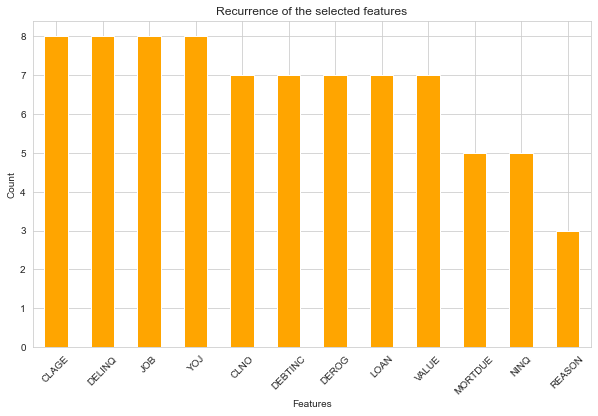

In [428]:
selected_features_recurrence(feat_selection_df)

<AxesSubplot:xlabel='Count'>

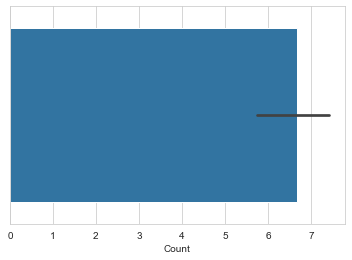

In [406]:
sns.barplot(data = pd.get_dummies(feat_selection_df['final_features'].apply(pd.Series).stack()).sum(level = 0).sum().reset_index().rename(columns = {'index':'Model', 0:'Count'}).sort_values('Count', ascending = False), x = 'Count', hue = 'Model')

In [412]:
def selected_features_dist(df: pd.DataFrame, export: bool = True):

    df_plot = (
               pd.concat(
                         (
                          df[['model_name']],
                          pd.get_dummies(
                                         df['final_features']
                                         .apply(pd.Series)
                                         .stack()
                                        )
                          .sum(level = 0)
                         ),
                         axis = 1
                        )
               .copy()
              )
    
    df_plot['totals'] = df_plot.drop('model_name', axis = 1).sum(axis = 1)
    df_plot = (
                df_plot
                .sort_values(by = 'totals',
                             ascending = False)
                .drop('totals', axis = 1)
              )
    df_plot.plot(
                 x = 'model_name',
                 y = [col for col in df_plot.columns if col != 'model_name'],
                 kind = 'bar',
                 stacked = True,
                 figsize = (10,6)
                )
    
    plt.title('Distribution of selected features', size = 15)
    plt.xlabel('Model', size = 11)
    plt.ylabel('Numver of selected features', size = 11)
    plt.xticks(rotation = 70, size = 11)
    plt.yticks(size = 11)
    plt.legend(bbox_to_anchor = (1, 1))


    if export:
        os.makedirs('./plots/', exist_ok = True)
        plt.savefig(f'./plots/Selected_Features_Distribution.jpg', dpi = 1200)
        
    plt.show()

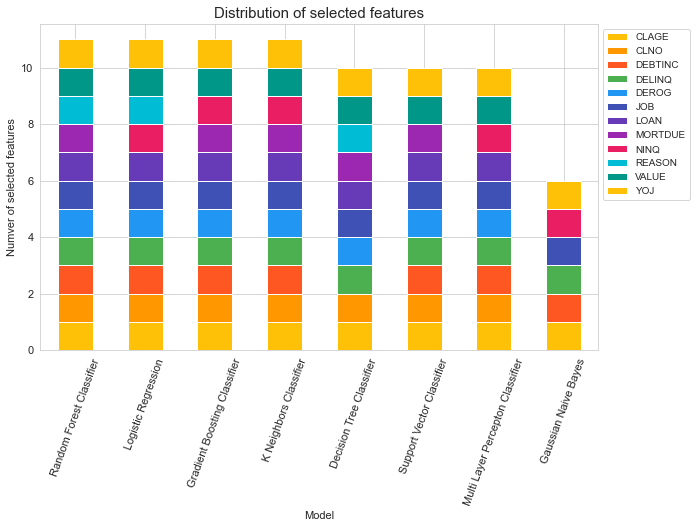

In [413]:
selected_features_dist(feat_selection_df)

In [149]:
def remove_duplicated_selected_feats(df:pd.DataFrame, export:bool = True) -> pd.DataFrame:
   
   #Filtering indices of duplicated selected features
   feat_duplicated_ind = (
                            df['final_features']
                           .apply( lambda x: ', '.join(x))
                           .duplicated(keep = False)
                           .values
                          )
   if sum(feat_duplicated_ind) != 0:
      #Keeping the model which was the fastest to execute and drop the others
      duplicated_models = (
                           df[feat_duplicated_ind]
                           .sort_values('execution_time')
                           .reset_index(drop = True)
                        )
    
      drop_models = (
                   duplicated_models
                   .loc[1:,'model_name']
                   .values
                  )
      
      keep_model = duplicated_models.head(1)['model_name'].values[0]

      models_name_join = ', '.join(duplicated_models['model_name'].tolist())
      
      final_feat_selection_df = (
                                df[~df['model_name'].isin(drop_models)]
                                .reset_index(drop = True)
                                )
      
      final_feat_selection_df.loc[final_feat_selection_df['model_name'] == keep_model, 'model_name'] = models_name_join
   else:
      final_feat_selection_df = df.copy()

   if export:
      with open('./models/feature_selection/feat_selection_df_FINAL.pkl', 'wb') as feat_select_df_save:
         pickle.dump(final_feat_selection_df, feat_select_df_save)

   return final_feat_selection_df

In [150]:
feat_selection_df_FINAL = remove_duplicated_selected_feats(feat_selection_df)
feat_selection_df_FINAL

,model_name,model,sfs_model,n_features,final_features,execution_time
0,Random Forest Classifier,"(DecisionTreeClassifier(criterion='entropy', m...",SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG...",27.725629
1,Logistic Regression,"LogisticRegression(C=1.025312821665419, class_...",SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ,...",1.636885
2,Decision Tree Classifier,"DecisionTreeClassifier(max_depth=4, max_featur...",SequentialFeatureSelector(cv=StratifiedKFold(n...,10,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG...",1.268244
3,Gaussian Naive Bayes,GaussianNB(var_smoothing=3.767743326483774e-07),SequentialFeatureSelector(cv=StratifiedKFold(n...,6,"[JOB, YOJ, DELINQ, CLAGE, NINQ, DEBTINC]",1.712611
4,"K Neighbors Classifier, Gradient Boosting Clas...","KNeighborsClassifier(algorithm='ball_tree', le...",SequentialFeatureSelector(cv=StratifiedKFold(n...,11,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",3.299212
5,Support Vector Classifier,"SVC(C=1.9654809949190868, class_weight='balanc...",SequentialFeatureSelector(cv=StratifiedKFold(n...,10,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",104.161200
6,Multi Layer Percepton Classifier,"MLPClassifier(activation='tanh', alpha=0.00688...",SequentialFeatureSelector(cv=StratifiedKFold(n...,10,"[LOAN, VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, ...",204.831130


In [151]:
feat_selection_df_FINAL[['model_name', 'n_features', 'final_features', 'execution_time']]

,model_name,n_features,final_features,execution_time
0,Random Forest Classifier,11,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG...",27.725629
1,Logistic Regression,11,"[LOAN, VALUE, REASON, JOB, YOJ, DEROG, DELINQ,...",1.636885
2,Decision Tree Classifier,10,"[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG...",1.268244
3,Gaussian Naive Bayes,6,"[JOB, YOJ, DELINQ, CLAGE, NINQ, DEBTINC]",1.712611
4,"K Neighbors Classifier, Gradient Boosting Clas...",11,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",3.299212
5,Support Vector Classifier,10,"[LOAN, MORTDUE, VALUE, JOB, YOJ, DEROG, DELINQ...",104.161200
6,Multi Layer Percepton Classifier,10,"[LOAN, VALUE, JOB, YOJ, DEROG, DELINQ, CLAGE, ...",204.831130


In [ ]:
def calc_opt_threshold(model, x:pd.DataFrame, y:pd.Series) -> float:

    y_scores = model.predict_proba(x)[:, 1]

    fpr, tpr, thresholds = roc_curve(y, y_scores)

    diff = abs(tpr - fpr)
    threshold = thresholds[np.argmax(diff)]

    return threshold

In [169]:
def hyperparameter_tuning(x_train:pd.DataFrame, y_train:pd.Series, x_val:pd.DataFrame, y_val:pd.Series,
                          models_dict:dict, feat_sel:pd.DataFrame, seed:int, target:str = 'BAD', export:bool = True) -> pd.DataFrame:
    
    """

    Function for hyperparameter tuning using Bayesian Optimization with 10-fold Stratified Cross Validation.

    Arguments:
        x_train - Data frame which contains features used for training the model.
        y_train - Data frame (or series) which contains labels for training the model.
        x_val - Data frame which contains features used for evaluation on validation set. (to select the final model)
        y_val -  Data frame (or series) which contains labels evaluation on validation set. (to select the final model)
        models_dict - Dictionary where the keys are model names and the values are the model objects with default hyperparameters.
        feat_sel - Data frame outputted by feat_selection() function which contains data about:
                    - each model such as model name, model itself tuned within feature selection, number and name of final features.
        seed - Globally defined random seed in order to preserve the reproducibility.

    For each model (with default hyperparameters) and for each set of selected features (by RFE),
        ... tune its hyperparameters on training set with given selected features,...
        ... and then use this optimized model for evaluation on validation set.
    Thus, each model should be fit on 4 different set of features.
        - hence for each model, we should have 4 different sets of tuned hyperparameters (4 different models), resulting in 16 tuned models.

    Output:
        Data frame:
            Columns:
                tuned_model_name - The name of the tuned model (the model within the models_dict parameter)
                fs_model_name - The name of the model which has been used in feature selection (which entered the RFE-CV in the previous step).
                fs_model - The model from feature selection itself (with given hyperparameters which were tuned within feature selection).
                tuned_model - The tuned model itself (the final model which will be tuned in this phase and then evaluated on validation set).
                rfe_model - RFE model itself (when applying transform() method, it should transform given X set on X set with optimal features).
                n_features - Number of features (in the training set) on which the tuned_model has been trained.
                final_features - The list of features on which the tuned_model has been trained.
                execution_time - How long it takes to tuned hyperparameters model (in seconds).
                ... Then follow the columns which are the metrics such as AUC, Gini, Brier, KS, Precision, Recall and F1.

    """
    model_selection_path = './models/model_selection/'

    #Metrics space.
    metrics = {
                'Recall': recall_score, 
                'Precision': precision_score, 
                'F1': f1_score,
                'Accuracy': accuracy_score,
                'AUC': roc_auc_score, 
                'Gini': roc_auc_score, 
                'KS': ks_2samp, 
                'Brier': brier_score_loss,
                }

    probs_evs = ['AUC','Brier']
    class_evs = ['Accuracy', 'Precision','Recall','F1']
    
    tuned_list = []

    dashes = '-------------------------------------------------------------------------------------------------------------------'
    no_dashes = len(dashes)
    count = 1

    #For each model, optimize it on the subset of optimal features on training set
        # and then evaluate it on validation set with filtered features (using set of several metrics).
    for name, mod in models_dict.items():
        
        for _, row in feat_sel.iterrows():

            fs_name, fs_mod, sfs = row['model_name'], row['model'], row['sfs_model']
            final_features = row['final_features']

            X_train_filtered = x_train[final_features]
            X_val_filtered = x_val[final_features]

            print(dashes)

            order = f'{count}/{len(models_dict.keys())*feat_sel.shape[0]}'
            no_dashes_left = int((no_dashes - len(order) - 1)/2)*"-"
            no_dashes_right  = f"{(no_dashes - len(order) - len(no_dashes_left) - 2)*'-'}"

            print(f'{no_dashes_left} {order} {no_dashes_right}')

            print(dashes)


            text_ = f'BAYESIAN OPTIMIZATION OF {name.upper()}'
            text__ = f'WITH SELECTED FEATURES BY {fs_name.upper()}'
            
            no_dashes_left_ = int((no_dashes - len(text_) - 1)/2)*"-"
            no_dashes_right_  = f"{(no_dashes - len(text_) - len(no_dashes_left_) - 2)*'-'}"
            no_dashes_left__ = int((no_dashes - len(text__) - 1)/2)*"-"
            no_dashes_right__  = f"{(no_dashes - len(text__) - len(no_dashes_left__) - 2)*'-'}"     

            print(f'{no_dashes_left_} {text_} {no_dashes_right_}')
            print(f'{no_dashes_left__} {text__} {no_dashes_right__}')
            print(dashes)
            print(dashes, '\n')


            print('    1/2 ... Starting Bayesian Optimization')


            start = time.time()

            opt_mod = bayesian_optimization(mod, X_train_filtered, y_train, seed)

            end = time.time()

            threshold = calc_opt_threshold(opt_mod, X_train_filtered, y_train)
            
            y_val_scores = opt_mod.predict_proba(X_val_filtered)[:, 1]
            y_val_preds = pd.Series(y_val_scores).apply(lambda x: 1 if x > threshold else 0)

            evs_list = []

            for metric in metrics.keys():
                if metric in probs_evs:
                    evs_list.append(metrics[metric](y_val, y_val_scores))
                elif metric in class_evs:
                    evs_list.append(metrics[metric](y_val, y_val_preds))
                elif metric == 'Gini':
                    evs_list.append(2* metrics['AUC'](y_val, y_val_scores) - 1)
                elif metric == 'KS':
                    X_Y_concat = pd.concat((y_val, X_val_filtered), axis = 1)
                    X_Y_concat['prob'] =  y_val_scores
                    evs_list.append(ks_2samp(X_Y_concat.loc[X_Y_concat[target] == 1, 'prob'],
                                            X_Y_concat.loc[X_Y_concat[target] == 0, 'prob'])[0])

            
            tuned_list.append([name,
                               fs_name,
                               opt_mod,
                               fs_mod,
                               sfs,
                               len(final_features),
                               final_features,
                               end - start,
                               threshold] + 
                               evs_list)

           #Exporting the final tuned model in .h5 format 
            if export:
                os.makedirs(model_selection_path, exist_ok = True)

                #Tuned model within SFS - Removing spaces in the model's name and replacing commas with underscores in case there are more models in the name
                save_fs_name = fs_name.replace(" ", "") if\
                                 ',' not in fs_name.replace(" ", "") else\
                                 '_'.join([j.replace(" ", "") for j in fs_name.split(', ')])
                
                #Final tuned model - Removing spaces in the model's name
                save_tuned_name = name.replace(" ", "")

                with open(f'{model_selection_path}models/FinalModel_{save_tuned_name}__SelectionWith_{save_fs_name}.h5', 'wb') as mod_save:
                    pickle.dump(opt_mod, mod_save)

            
            print('    2/2... Bayesian Optimization finished', '\n')

            print(f'    Execution time: {round(end - start)} seconds', '\n')
            print(f'    Recall Score on Validation set: {evs_list[0]}', '\n')

            
            print(f'   Tuned hyperparameters of {name}:', opt_mod.get_params())
            
            print('-------------------------------------------------------------------------------------------------------------------', '\n')

            count += 1


    model_selection_df = (
                           pd.DataFrame(tuned_list,
                           
                                        columns = ['tuned_model_name', 'fs_model_name',
                                                   'tuned_model', 'fs_model',
                                                   'sfs_object', 'n_features',
                                                   'final_features', 'execution_time',
                                                   'threshold'] + list(metrics.keys())
                                       )
                                        .sort_values(
                                                      ['Recall', 'F1', 'Precision', 'Accuracy',
                                                       'AUC', 'Gini', 'KS', 'Brier'],

                                                      ascending = [False, False, False, False,
                                                                   False, False, False, True]
                                        )
                                        .reset_index(drop = True)
                        )
                                        
    
    if export:
        with open(f'{model_selection_path}model_selection_df.pkl', 'wb') as model_select_df_save:
            pickle.dump(model_selection_df, model_select_df_save)

    return model_selection_df

In [170]:
hipopo = hyperparameter_tuning(X_train_binned ,y_train, X_valid_binned, y_valid, models_dict, feat_selection_df_FINAL, seed)

-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- 1/56 ------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
-------------------------------- BAYESIAN OPTIMIZATION OF RANDOM FOREST CLASSIFIER --------------------------------
-------------------------------- WITH SELECTED FEATURES BY RANDOM FOREST CLASSIFIER -------------------------------
-------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------- 

    1/2 ... Starting Bayesian Optimization
    2/2... Bayesian Optimization finished 

    Execution time: 14 seconds 

    Recall Score on Validation set: 0.8435754189944135 

   Tuned 

In [227]:
def data_filter_join(hyp_tuning_df: pd.DataFrame, x_train: pd.DataFrame,
                     x_valid: pd.DataFrame, x_test: pd.DataFrame,
                     y_train: pd.Series, y_valid: pd.Series,
                     model_order:int = 0) -> tuple[pd.Series, pd.DataFrame, pd.DataFrame]:

    """

    Function which joins the training and validation sets of features and labels into one set.
        - then filters only the relevant final features only (the latter also applies to the test set as well).

    Arguments:
        hyp_tuning_df - Data frame outputted by hyperparameter_tuning() function
                      - contains data about each tuned model such as the model name, model itself, number and name of the final features, scores.
        x_train - Data frame of training set of features data.
        x_valid - Data frame of validation set of features data.
        x_test - Data frame of test set of features data.
        y_train - Data frame/Series of true labels from training set.
        y_valid - Data frame/Series of true labels from validation set.
        model_order - by default 0, is we want to select the highest ranked model (which has row index 0 in hyp_tuning_df)
        
    Outputs:
        y_train_valid - Data frame/Series with joined true labels from training and validation sets.
        x_train_valid_filtered - Data frame with joined features' data from training and validation sets, containing final features only.
        x_test_filtered - Data frame with features' data from test set, containing final features only.
        
    """
    
    final_features = [feat for feat in hyp_tuning_df.loc[model_order, 'final_features']]

    y_train_valid = pd.concat((y_train, y_valid))
    x_train_valid_filtered = pd.concat((x_train, x_valid))[final_features]
    x_test_filtered = x_test[final_features]

    return (y_train_valid, x_train_valid_filtered, x_test_filtered)

In [228]:
y_train_valid, X_train_valid_binned_filtered, X_test_binned_filtered = data_filter_join(hipopo, X_train_binned, X_valid_binned,
                                                                                        X_test_binned, y_train, y_valid)

In [229]:
preprocessed = prep_data_export((X_train_valid_binned_filtered, X_test_binned_filtered),
                                    (y_train_valid, y_test),
                                    ('Training_Validation', 'Test'),
                                    csv_name = 'preprocessed')

In [232]:
def final_model_fit(hyp_tuning_df: pd.DataFrame,
                    x_fit: pd.DataFrame, y_fit: pd.Series,
                    model_order: int = 0,
                    save_models: list[bool, bool, bool] = [True, True, True]):

    """

    Function for building/fitting the final, tuned, chosen model on the joined training and validation sets.
        - Optionally, it can either export final model, feature selection and/or RFE object which are related to the final model.
    
    Arguments:
        x_fit - Data frame containing features data, on which the data will be trained.
        y_fit - Data frame/Series containing label data, on which the data will be trained.
        hyp_tuning_df - Data frame outputted by hyperparameter_tuning() function,
                      - contains data about each tuned model such as the model name, model itself, number and name of the final features, scores.
        model_order - by default 0, is we want to select the highest ranked model (which has row index 0 in hyp_tuning_df)
        save_models - list of 3 Booleans which indicates whether to save given models in the h5 format.
            - 1st Boolean for saving the tuned feature selection model.
            - 2nd Boolean for saving the fit RFE model.
            - 3rd Boolean for saving the final, tuned model.
        
    Output:
        - fitted model

    """

    final_model = hyp_tuning_df.loc[model_order,"tuned_model"]

    final_model.fit(x_fit, y_fit)

    if save_models[0]:
        fs_model = hyp_tuning_df.loc[model_order, 'fs_model']
        fs_model_file = open("feature_selection_model.h5", "wb")
        pickle.dump(fs_model, fs_model_file)
        fs_model_file.close()

    if save_models[1]:
        sfs_model = hyp_tuning_df.loc[model_order, "sfs_object"]
        sfs_model_file = open("sfs_object.h5", "wb")
        pickle.dump(sfs_model, sfs_model_file)
        sfs_model_file.close()

        
    if save_models[2]:
        final_model = hyp_tuning_df.loc[model_order, 'tuned_model']
        final_model_file = open("final_modelL.h5", "wb")
        pickle.dump(final_model, final_model_file)
        final_model_file.close()

    return final_model

In [233]:
final_model = final_model_fit(hipopo, X_train_valid_binned_filtered, y_train_valid)

In [200]:
def final_threshold(hyp_tuning_df: pd.DataFrame, model_order: int = 0) -> float:

    threshold = hyp_tuning_df.loc[model_order, 'threshold']
    
    return threshold

In [201]:
opt_threshold = final_threshold(hipopo, 36)

In [202]:
opt_threshold

0.34241155368319415

In [196]:
final_model

MLPClassifier(activation='tanh', alpha=0.006888415238216396,
              beta_1=2.7374607208573118e-05, beta_2=0.002076431888599224,
              early_stopping=True, epsilon=1.6023972045189056e-09,
              hidden_layer_sizes=45, learning_rate='invscaling',
              learning_rate_init=0.0001777875044793026,
              momentum=0.035266313967764876, nesterovs_momentum=False,
              power_t=0.28656642565207063, random_state=123, shuffle=False)

In [243]:
def conf_mat(model, X: pd.DataFrame, y: pd.Series, threshold: float) -> pd.DataFrame:

    """

    Function for outputting the confusion matrix as a data frame.
    
    Arguments:
        y_actuals - Data frame or series of test true labels
        model - fitted model ready for prediction.
        sample - Data frame of test features.
        
    Output:
        Data frame - confusion matrix
        
    """
    y_scores = pd.Series(model.predict_proba(X)[:, 1])
    y_preds = y_scores.apply(lambda x: 1 if x > threshold else 0)

    confm = pd.DataFrame(
                         confusion_matrix(y, y_preds),
                         columns = ['Predicted - Non-Default', 'Predicted - Default'],
                         index = ['Actual - Non-Default', 'Actual - Default']
                        )
    return confm

In [244]:
conf_mat(final_model, X_test_binned_filtered, y_test, opt_threshold)

,Predicted - Non-Default,Predicted - Default
Actual - Non-Default,636,80
Actual - Default,39,139


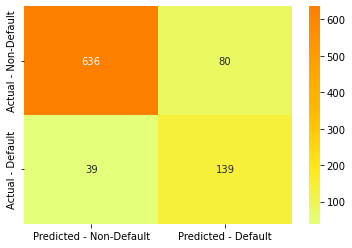

In [209]:
sns.heatmap(conf_mat(y_test, final_model, X_test_binned_filtered, opt_threshold),
                annot = True, cmap ='Wistia', fmt = 'g')
plt.show()

In [239]:
def evaluation_metrics(model, X: pd.DataFrame, y: pd.Series,
                       threshold: float, target: str = 'BAD'):

    """

    Function for outputting a data frame which depicts a list of evaluation metrics and scores of given model.
        - based on the dataset on which the model is being evaluated.
    
    Arguments:
        x_set - Data frame of test data of features.
        true_labels - Data frame or Series of test data of true labels.
        model - fitted model ready for prediction.
        metrics_list - List of metrics as strings which we want to calculate.

    Output:
        Data frame with metrics' names and their values for given model.
        
    """

    metrics = {'F1': f1_score,
                'Precision': precision_score, 
                'Recall': recall_score, 
                'Accuracy': accuracy_score,
                'AUC': roc_auc_score,
                'Gini': roc_auc_score,
                'KS': ks_2samp, 
                'Brier': brier_score_loss}


    probs_evs = ['AUC','Brier']
    class_evs = ['Precision','Recall','F1', 'Accuracy']
    evs_list = []

    y_scores = model.predict_proba(X)[:, 1]
    y_preds = pd.Series(y_scores).apply(lambda x: 1 if x > threshold else 0)
    
    for metric in metrics.keys():
        if metric in probs_evs:
            evs_list.append([metric, metrics[metric](y, y_scores)])
        elif metric in class_evs:
            evs_list.append([metric, metrics[metric](y, y_preds)])
        elif metric == 'Gini':
            evs_list.append([metric, 2 * metrics[metric](y, y_scores) - 1])
        elif metric == 'KS':
            X_Y_concat = pd.concat((y, X), axis = 1)
            X_Y_concat['prob'] =  y_scores
            evs_list.append([metric, metrics[metric](X_Y_concat.loc[X_Y_concat[target] == 1, 'prob'],
                                                     X_Y_concat.loc[X_Y_concat[target] == 0, 'prob'])[0]])

    evaluation_df = pd.DataFrame(evs_list, columns = ['Metric', 'Score'])

    return evaluation_df

In [241]:
evaluation_metrics(final_model, X_test_binned_filtered, y_test, opt_threshold)

,Metric,Score
0,F1,0.700252
1,Precision,0.634703
2,Recall,0.780899
3,Accuracy,0.866890
4,AUC,0.915126
5,Gini,0.830252
6,KS,0.680560
7,Brier,0.083381


In [184]:
mod = hipopo.sort_values('Recall', ascending = False).head(1)['tuned_model'].values[0]

mod.fit(X_train_binned, y_train)

MLPClassifier(activation='tanh', alpha=0.006888415238216396,
              beta_1=2.7374607208573118e-05, beta_2=0.002076431888599224,
              early_stopping=True, epsilon=1.6023972045189056e-09,
              hidden_layer_sizes=45, learning_rate='invscaling',
              learning_rate_init=0.0001777875044793026,
              momentum=0.035266313967764876, nesterovs_momentum=False,
              power_t=0.28656642565207063, random_state=123, shuffle=False)

In [179]:
hipopo[['tuned_model_name', 'fs_model_name', 'n_features', 'threshold',  'Recall', 'Precision', 'F1', 'Accuracy', 'AUC', 'Gini',
       'KS', 'Brier']].sort_values('Recall', ascending = False)

,tuned_model_name,fs_model_name,n_features,threshold,Recall,Precision,F1,Accuracy,AUC,Gini,KS,Brier
36,Multi Layer Percepton Classifier,"K Neighbors Classifier, Gradient Boosting Clas...",11,0.342412,0.860335,0.523810,0.651163,0.815642,0.901322,0.802643,0.671788,0.101981
27,Random Forest Classifier,Support Vector Classifier,10,0.353208,0.854749,0.550360,0.669584,0.831285,0.910252,0.820503,0.681564,0.107676
35,Gaussian Naive Bayes,Gaussian Naive Bayes,6,0.153778,0.849162,0.531469,0.653763,0.820112,0.876042,0.752083,0.662011,0.115090
30,Random Forest Classifier,"K Neighbors Classifier, Gradient Boosting Clas...",11,0.353892,0.849162,0.539007,0.659436,0.824581,0.910560,0.821120,0.677374,0.108663
28,Random Forest Classifier,Random Forest Classifier,11,0.355846,0.843575,0.551095,0.666667,0.831285,0.909858,0.819715,0.681564,0.107666
24,Random Forest Classifier,Multi Layer Percepton Classifier,10,0.380825,0.832402,0.568702,0.675737,0.840223,0.911996,0.823991,0.692737,0.108458
23,Logistic Regression,Gaussian Naive Bayes,6,0.475651,0.826816,0.571429,0.675799,0.841341,0.894019,0.788037,0.699721,0.118479
17,Gradient Boosting Classifier,Gaussian Naive Bayes,6,0.187915,0.826816,0.584980,0.685185,0.848045,0.894974,0.789949,0.694134,0.084266
14,Random Forest Classifier,Logistic Regression,11,0.400010,0.821229,0.600000,0.693396,0.854749,0.911879,0.823757,0.702514,0.108501
34,Logistic Regression,"K Neighbors Classifier, Gradient Boosting Clas...",11,0.460556,0.821229,0.546468,0.656250,0.827933,0.907135,0.814269,0.663408,0.112913


In [236]:
def ROC_curve_plot(model, X: pd.DataFrame, y: pd.Series):

    """

    Function for plotting the ROC curve.

    Arguments:
        y_test_true - Data frame/Series containing labels data from test set.
        x_test - Data frame containing features data from test set.
        model - The fitted model ready for predictions.
    
    Output:
        ROC plot

    """

    y_scores = model.predict_proba(X)[:, 1]
    FPR, TPR, _ = roc_curve(y, y_scores)
    AUC = round(roc_auc_score(y, y_scores), 2)

    fig, ax = plt.subplots()
    plt.title('Receiver Operating Characteristic Curve')

    ax.plot(FPR, TPR, 'b', label =f"AUC = {AUC}")
    ax.plot([0, 1], [0, 1], 'r--')

    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive rate')

    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    plt.grid()
    plt.legend()
    plt.show()

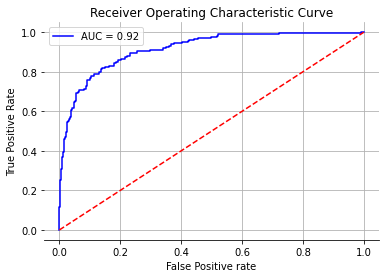

In [238]:
ROC_curve_plot(final_model, X_test_binned_filtered, y_test)

In [224]:
def learning_curve_plot(model, x_set: pd.DataFrame, y_set: pd.Series, seed: int):

    """

    Function for plotting the learning curve.

    Arguments:
        model - Fitted model ready for predictions.
        x_set - Data frame containing features data on which the model has been trained on.
        y_set - Data frame/series containing labels data on which the model has been trained on.
        seed - Globally defined random seed in order to preserve the reproducibility.

    Output - Plot of learning curve on training set and hold out set.

    """
    
    train_sizes, train_scores, test_scores = learning_curve(model, x_set, y_set,
                                                    cv = 10, scoring = 'recall',
                                                    train_sizes = np.linspace(0.01, 1.0, 100),
                                                    random_state = seed)

    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)

    plt.plot(train_sizes, train_mean,
                color = 'blue', marker = 'o',
                markersize = 3,
                label = 'Training F1 score')

    plt.fill_between(train_sizes,
                        train_mean + train_std,
                        train_mean - train_std,
                        alpha = 0.2, color = 'blue')

    plt.plot(train_sizes, test_mean,
                color = 'green', marker = 'o',
                linestyle = '--', markersize = 3,
                label = 'Test F1 score')

    plt.fill_between(train_sizes,
                        test_mean + test_std,
                        test_mean - test_std,
                        alpha = 0.2, color = 'green')
    
    plt.title('Learning Curve')
    plt.xlabel('Training set size')
    plt.ylabel('F1 score')

    plt.grid()
    plt.legend(loc = 'best')
    plt.show()

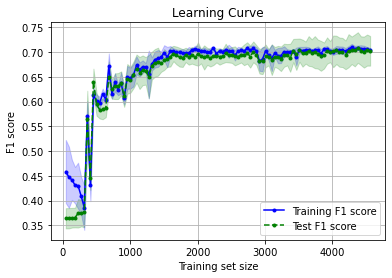

In [225]:
learning_curve_plot(final_model, X_train_valid_binned_filtered, y_train_valid, seed)